<a href="https://colab.research.google.com/github/Alf-caput/LAB03_Clasificacion/blob/main/LAB03_Clasificacion_entrega.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LAB03: Clasificación
##### Grupo: B05

Inicialmente se descomprime el archivo zip que contiene los datasets

Si estamos utilizando google colab, en vez de clonar el repositorio, con wget obtenemos el zip que contiene los datasets:

In [85]:
import os

zip_filename = 'Recursos Lab3.zip'
url = 'https://github.com/Alf-caput/LAB03_Clasificacion/raw/main/Recursos%20Lab3.zip'

if not os.path.exists(zip_filename):
    os.system('wget' + ' ' + url)

Junto con las librerías requeridas

In [86]:
import os

requirements = 'requirements.txt'
url = 'https://github.com/Alf-caput/LAB03_Clasificacion/raw/main/requirements.txt'

if not os.path.exists(requirements):
    os.system('wget' + ' ' + url)

os.system('pip install -r requirements.txt')

0

In [87]:
from zipfile import ZipFile
import os

zip_filename = 'Recursos Lab3.zip'
base_dir = os.path.splitext(zip_filename)[0] + '/'

if not os.path.exists(base_dir):
    with ZipFile(zip_filename, 'r') as zf:
        for file in zf.namelist():
            if file.startswith(base_dir):
                zf.extract(file)

### PRÁCTICA 1 LAB 03: Técnicas y Modelos de Clasificación

A partir de datos sobre características de tumores, se desea llevar a cabo un Decision Support System para comprender las características que más influyen en el diagnóstico de cáncer de mama.

Un Decision Support System es un sistema computacional basado en minería de datos que brinda información para tomar una decisión.  

Primero se carga el dataset 'cancer.csv':

In [88]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

base_dir = 'Recursos Lab3/'
filename = 'cancer.csv'

df = pd.read_csv(os.path.join(base_dir, filename))
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


Frecuencia por diagnóstico: es interesante evaluar esta frecuencia, pues la descompensación que pueda existir en cuántas veces aparezca una etiqueta repercute en nuestro modelo.

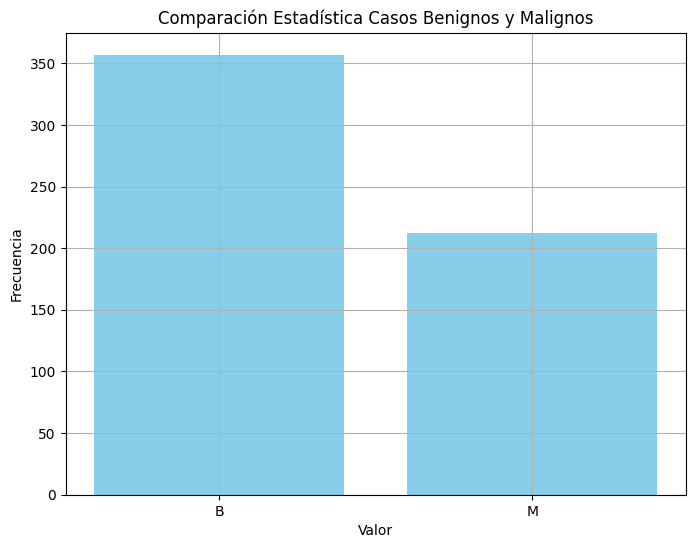

In [89]:
tabla_frecuencias = df['diagnosis'].value_counts().reset_index()
tabla_frecuencias.columns = ['Valor', 'Frecuencia']
plt.figure(figsize=(8, 6))
plt.bar(tabla_frecuencias['Valor'], tabla_frecuencias['Frecuencia'], color='skyblue')
plt.xlabel('Valor')
plt.ylabel('Frecuencia')
plt.title('Comparación Estadística Casos Benignos y Malignos')
plt.grid(True)
plt.show()

Se puede ver que hay una gran cantidad de datos más de tumores benignos que malignos.  Hay aproximadamente una diferencia de un 57%.  Esto puede aumentar la posibilidad de falsos positivos.

# 1) Preprocesamiento de los datos.

Analizar datos NaN:

In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

Hay una columna, 'Unnamed' que contiene 596 datos nulos.  No hay información sobre ellos.  Se elimina dicha columna.



In [91]:
df = df.drop(columns = ['Unnamed: 32'])

A continuación se analizará la correlación cruzada, que brinda información sobre las relaciones entre las variables y su respectivo diagnóstico, es decir, sirve para observar qué variables tienen mayor influencia en el entrenamiento del modelo.  Es relevante eliminar variables que sean muy dependientes de otras.  Se graficará un mapa de calor que indica la relación porcentual entre variables

Es necesario transformar la variable 'diagnosis'.  Esta toma valores 'B' y 'M', lo cual corresponde a Beningno y Maligno respectivamente.  Para poder trabajar con esta variable, se pasan los valores a 0 y 1 (1 es el caso de 'éxito', que es que el tumor sea maligno).

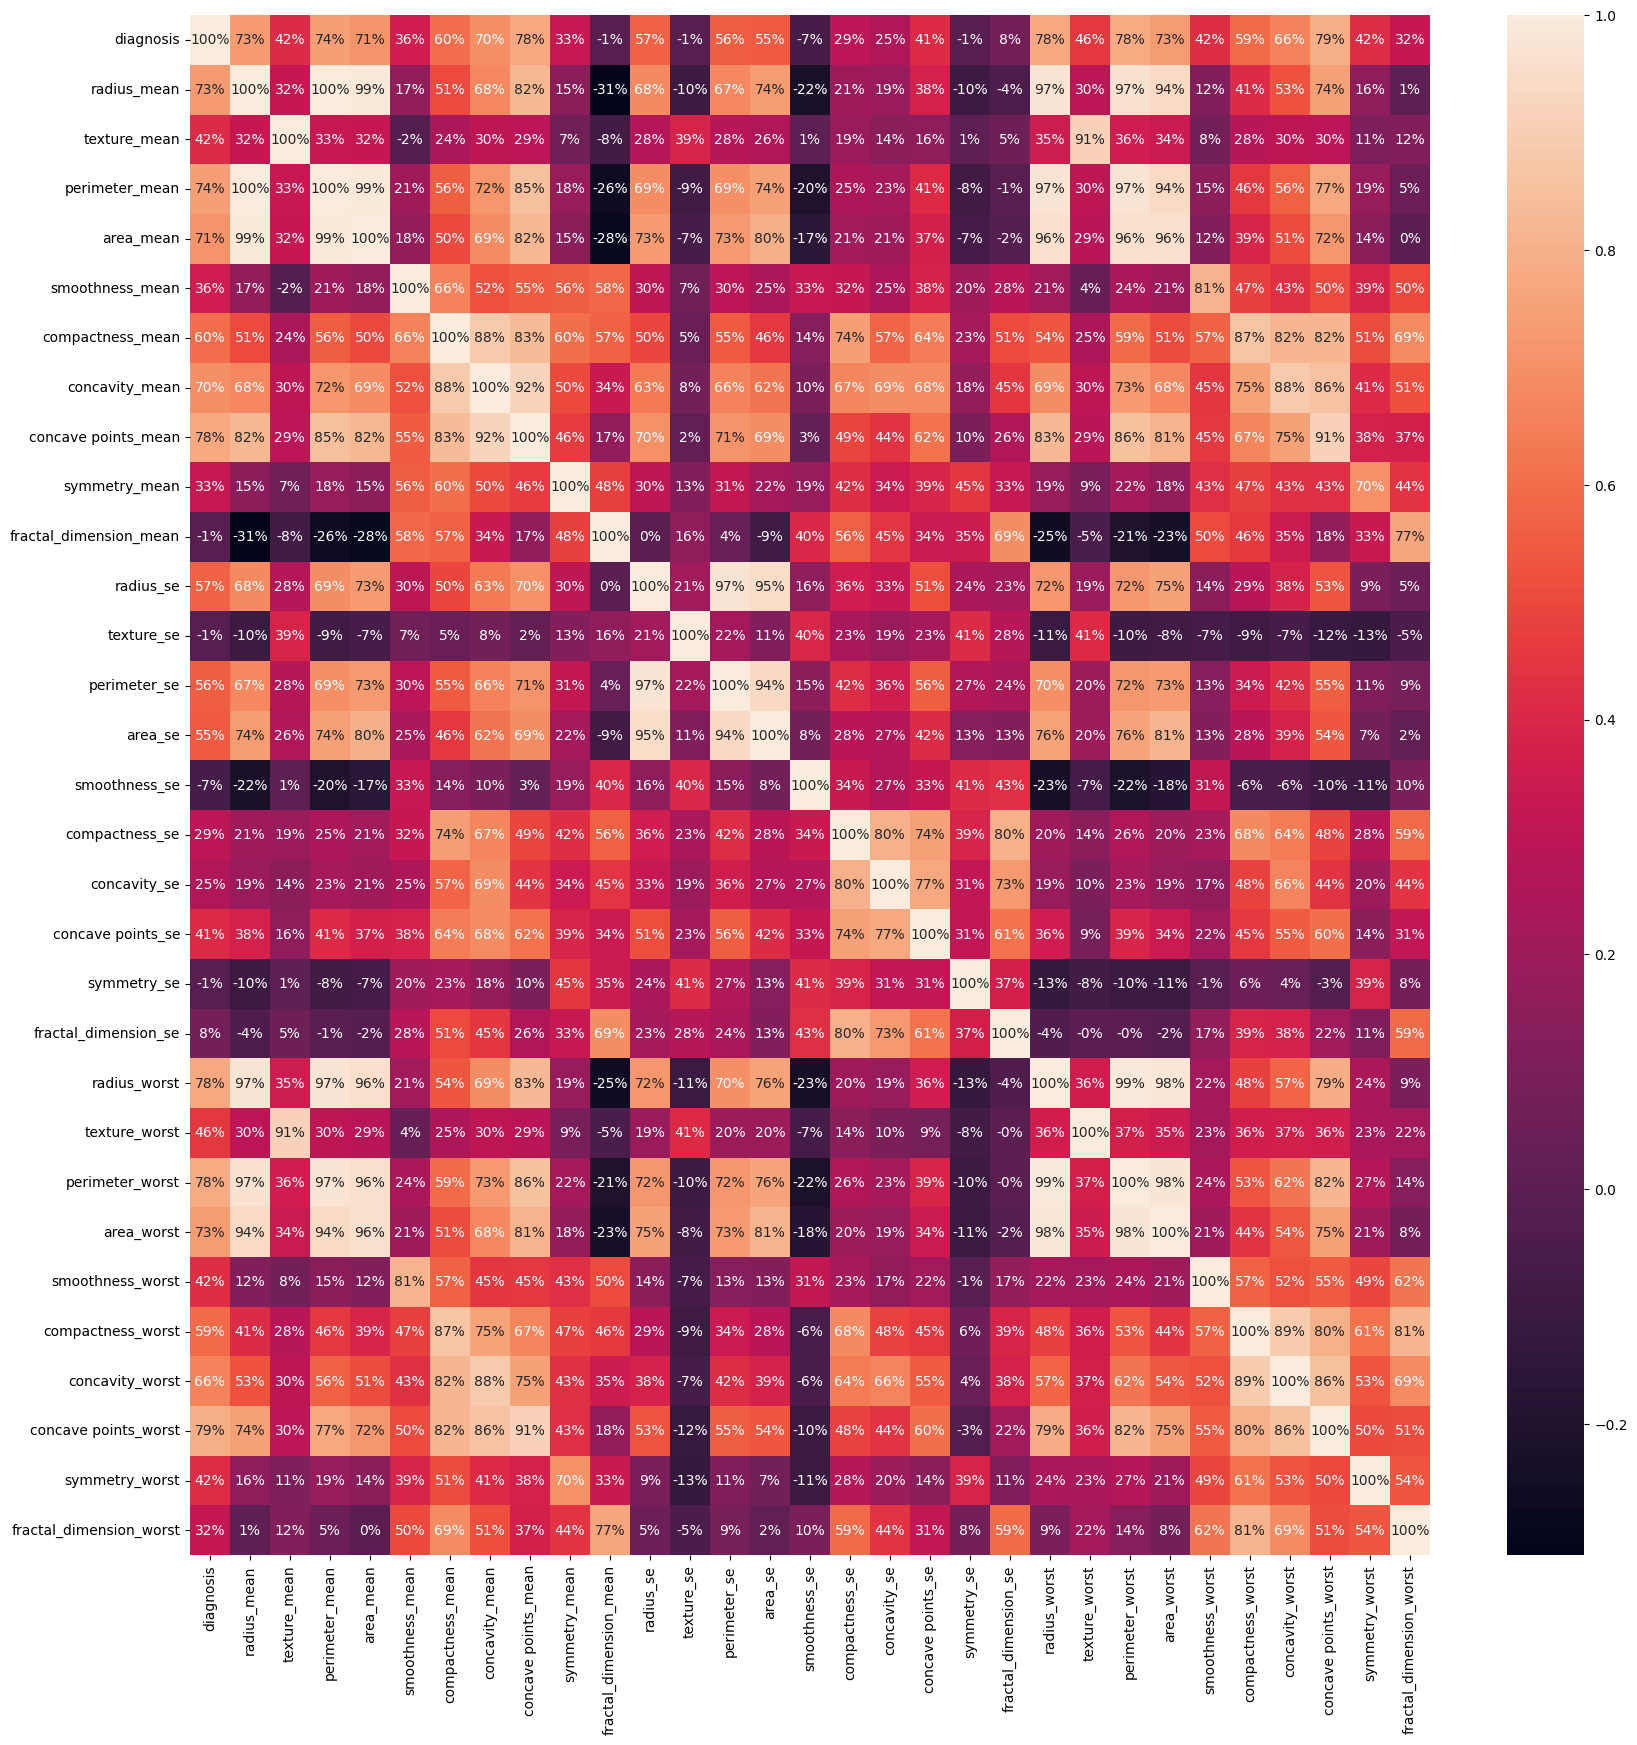

In [92]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

df['diagnosis'] = label_encoder.fit_transform(df['diagnosis'])

df_new = df.drop(columns = ['id'])

plt.figure(figsize=(20, 20))
sns_plot = sns.heatmap(df_new.corr(), annot=True, fmt='.0%')
plt.show()

Se observa que las características que más influyen en que el diagnóstico sea maligno son  **concave points_worst, area_worst, perimeter_worst, radius_worst, concave points_mean, radius_mean, perimeter_mean y area_mean** , con unas relaciones un poco menores al 80%.  Existe una relación directamente proporcional, es decir, a mayor valor tomen, más probable es que el diagnóstico sea Maligno.  
Estas variables no se eliminarán, todo el resto sí, excepto alguna de las otras que tenga cierta relación con la variable objetivo y así no perder generalidad.  Estas serán: **compactness_mean y concavity_worst**.

In [93]:
df_new = df_new.drop(columns = ['texture_mean','smoothness_mean','concavity_mean','symmetry_mean','fractal_dimension_mean','radius_se','texture_se','perimeter_se','area_se','smoothness_se','compactness_se','concavity_se','concave points_se','symmetry_se','fractal_dimension_se','texture_worst','smoothness_worst','compactness_worst','symmetry_worst','fractal_dimension_worst'])

A continuación se imprimirán los coeficientes de correlación de las variables que sean muy dependientes (mayores a 0.8).   Primero en forma matricial.

In [94]:
correlation_matrix = df_new.corr()

high_correlation = correlation_matrix[(correlation_matrix >= 0.8) & (correlation_matrix < 1.0)]
print("Variables con coeficiente de correlación mayor o igual a 0.8:")
print(high_correlation.dropna(axis=1, how='all').dropna(axis=0, how='all').to_string(na_rep=''))

Variables con coeficiente de correlación mayor o igual a 0.8:
                      radius_mean  perimeter_mean  area_mean  compactness_mean  concave points_mean  radius_worst  perimeter_worst  area_worst  concavity_worst  concave points_worst
radius_mean                              0.997855   0.987357                               0.822529      0.969539         0.965137    0.941082                                       
perimeter_mean           0.997855                   0.986507                               0.850977      0.969476         0.970387    0.941550                                       
area_mean                0.987357        0.986507                                          0.823269      0.962746         0.959120    0.959213                                       
compactness_mean                                                                           0.831135                                                    0.816275              0.815573
concave points_mean      0.8

Ahora se muestran los pares de variables muy dependientes.

In [95]:
correlation_matrix = df_new.corr()

print('Las variables más dependientes entre sí son:\n')
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        correlation = correlation_matrix.iloc[i, j]
        if correlation >= 0.9:
            var1 = correlation_matrix.columns[i]
            var2 = correlation_matrix.columns[j]
            print(f"{var1} y {var2}")


Las variables más dependientes entre sí son:

radius_mean y perimeter_mean
radius_mean y area_mean
radius_mean y radius_worst
radius_mean y perimeter_worst
radius_mean y area_worst
perimeter_mean y area_mean
perimeter_mean y radius_worst
perimeter_mean y perimeter_worst
perimeter_mean y area_worst
area_mean y radius_worst
area_mean y perimeter_worst
area_mean y area_worst
concave points_mean y concave points_worst
radius_worst y perimeter_worst
radius_worst y area_worst
perimeter_worst y area_worst


Al haber varias variables que se refieren a la misma característica del tumor, es interesante estudiar la correlación entre ellas.  
Todas las variables que se refieren a la misma característica están relacionadas, por lo que habrá que eliminar algunas variables.  Se eliminarán las que menos relación tengan con la variable objetivo, que son : **radius_mean, perimeter_mean, area_mean y concave points_mean**.

In [96]:
df_new = df_new.drop(columns = ['radius_mean','perimeter_mean','area_mean','concave points_mean'])
df_new.describe()

,diagnosis,compactness_mean,radius_worst,perimeter_worst,area_worst,concavity_worst,concave points_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,0.372583,0.104341,16.269190,107.261213,880.583128,0.272188,0.114606
std,0.483918,0.052813,4.833242,33.602542,569.356993,0.208624,0.065732
min,0.000000,0.019380,7.930000,50.410000,185.200000,0.000000,0.000000
25%,0.000000,0.064920,13.010000,84.110000,515.300000,0.114500,0.064930
50%,0.000000,0.092630,14.970000,97.660000,686.500000,0.226700,0.099930
75%,1.000000,0.130400,18.790000,125.400000,1084.000000,0.382900,0.161400
max,1.000000,0.345400,36.040000,251.200000,4254.000000,1.252000,0.291000


Para simplificar los datos, se pasarán a categóricos con 3 valores las variables que midan área, perímetro y compacidad.

area_worst oscila entre los valores 185.2 y 4254.   
perimeter_worst oscial entre los valores 50.41 y 251.2.  
compactness_mean toma valores desde 0.019380 hasta 0.3454.

In [97]:
#AREA
bins = [185, 670, 1084, 4254]
labels = ['Baja', 'Media', 'Alta']
df_new['area_worst_categ'] = pd.cut(df_new['area_worst'], bins=bins, labels=labels)

In [98]:
#PERÍMETRO
bins = [50, 170, 200, 252]
labels = ['Bajo', 'Medio', 'Alto']
df_new['perimeter_worst_categ'] = pd.cut(df_new['perimeter_worst'], bins=bins, labels=labels)

In [99]:
#COMPACIDAD
bins = [0.0193,0.06492,0.1304,0.3455]
labels = ['Baja', 'Media', 'Alta']
df_new['compactness_mean_categ'] = pd.cut(df_new['compactness_mean'], bins=bins, labels=labels)

In [100]:
df_new = df_new.drop(columns = ['area_worst','perimeter_worst','compactness_mean'])
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   diagnosis               569 non-null    int64   
 1   radius_worst            569 non-null    float64 
 2   concavity_worst         569 non-null    float64 
 3   concave points_worst    569 non-null    float64 
 4   area_worst_categ        569 non-null    category
 5   perimeter_worst_categ   569 non-null    category
 6   compactness_mean_categ  569 non-null    category
dtypes: category(3), float64(3), int64(1)
memory usage: 20.0 KB


Pasar a variable dummy las variables categorizadas.

In [101]:
df_new = pd.get_dummies(df_new, columns=['area_worst_categ','perimeter_worst_categ','compactness_mean_categ'])

2) Modelos de clasificación.

ÁRBOLES DE DECISIÓN  
Primero se prueba con el criterio 'entropy'.

In [102]:
from sklearn.model_selection import train_test_split
y = df_new['diagnosis']
X = df_new.iloc[:,1:]
#dividir los datos en datos de entrenamiento y de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [103]:
#crear el árbol
from sklearn.tree import DecisionTreeClassifier
algoritmo = DecisionTreeClassifier(criterion = 'entropy')

In [104]:
algoritmo.fit(X_train, y_train)
# predecir con valores nunca vistos
y_pred = algoritmo.predict(X_test)

In [105]:
# matriz de confusión
from sklearn.metrics import confusion_matrix
matriz = confusion_matrix(y_test, y_pred)
print('Matriz de Confusión:')
print(matriz)

Matriz de Confusión:
[[66  2]
 [ 2 44]]


En problemas sobre salud, suele buscarse minimizar los falsos negativos.

Tomando el resultado de este árbol de decisión: en cada ejecución del mismo suelen clasificarse mal un 8-9% de los datos, sin una significante distinción entre los falsos negativos y los falsos positivos.

In [106]:
# precisión del modelo
from sklearn.metrics import precision_score
precision = precision_score(y_test, y_pred)
print('Precisión del modelo:')
print(precision)

Precisión del modelo:
0.9565217391304348


La precisión de este modelo va de 83% a 95%.  Para este tipo de problemas se busca una precisión cercana al 100%, por lo que no está mal.  El error se debe a variables omitidas, pero teniendo en cuenta que se han eliminado la mayoría, el modelo tiene mucha validez y rango de mejora.  Ahora se prueba con el criterio 'gini'.

In [107]:
algoritmo = DecisionTreeClassifier(criterion = 'gini')
algoritmo.fit(X_train, y_train)
y_pred = algoritmo.predict(X_test)
from sklearn.metrics import confusion_matrix
matriz = confusion_matrix(y_test, y_pred)
print('Matriz de Confusión:')
print(matriz)
from sklearn.metrics import precision_score
precision = precision_score(y_test, y_pred)
print('Precisión del modelo:')
print(precision)

Matriz de Confusión:
[[66  2]
 [ 1 45]]
Precisión del modelo:
0.9574468085106383


Con la métrica GINI, el modelo es ligeramente mejor pero no minimiza tampoco los falsos negativos.

Ahora se probará el método de clasificación K-Nearest Neighbours.

In [108]:
import statsmodels.api as sm

import scipy
from scipy import stats

from sklearn.metrics import classification_report

from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [109]:
knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=15)

In [110]:
X_test = X_test.dropna()
predicciones = knn.predict(X_test)
comparaciones = pd.DataFrame(X_test)
comparaciones = comparaciones.assign(Diagnosis_Real = y_test)
comparaciones = comparaciones.assign(Diagnosis_Pred = predicciones.flatten().tolist())

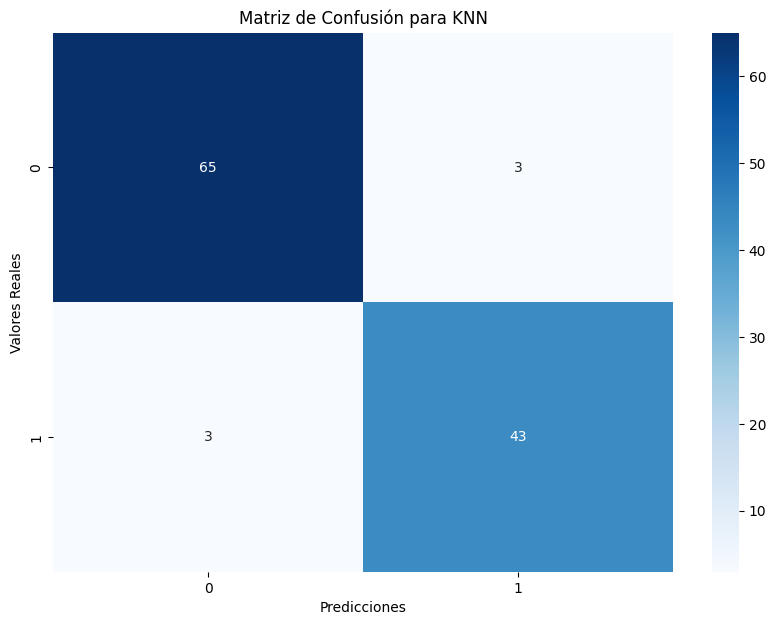

In [111]:
matriz_conf = confusion_matrix(comparaciones['Diagnosis_Real'], comparaciones['Diagnosis_Pred'])

plt.figure(figsize=(10, 7))
sns.heatmap(matriz_conf, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicciones')
plt.ylabel('Valores Reales')
plt.title('Matriz de Confusión para KNN')
plt.show()

En este modelo de clasificación hay un número considerable de falsos negativos.  Hay un 11% aproximadamente de falsos negativos con respecto de los positivos totales y 0% de falsos positivos.  Esto es precisamente lo que no interesa en un modelo predictor de diagnósticos de tumores, pues es preferible que haya falsos positivos (que se diagnostique y no se tenga) a que haya falsos negativos (que se tenga y no se diagnostique).

In [112]:
print(classification_report(comparaciones['Diagnosis_Real'], comparaciones['Diagnosis_Pred']))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96        68
           1       0.93      0.93      0.93        46

    accuracy                           0.95       114
   macro avg       0.95      0.95      0.95       114
weighted avg       0.95      0.95      0.95       114



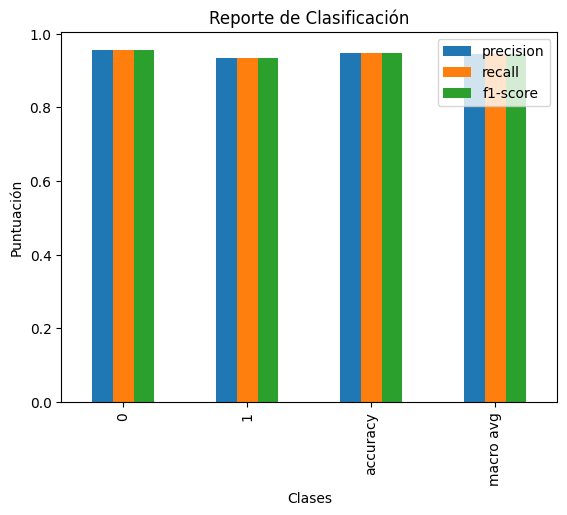

In [113]:
# graficar tabla anterior
report = classification_report(comparaciones['Diagnosis_Real'], comparaciones['Diagnosis_Pred'], output_dict=True)

report_df = pd.DataFrame(report).transpose()

report_df = report_df[:-1]
report_df[['precision', 'recall', 'f1-score']].plot(kind='bar')
plt.title('Reporte de Clasificación')
plt.xlabel('Clases')
plt.ylabel('Puntuación')
plt.show()

El modelo de KNN predice mejor las clases negativas, que en este caso es tumor BENIGNO.  
  Recall se refiere a la sensibilidad.  Este modelo identifica mejor los casos reales de la clase 0 también.  
  Hay un buen equilibrio entre precisión y recall, como se observa en f1_score.  
  

In [114]:
accuracy = accuracy_score(
    y_true = comparaciones['Diagnosis_Real'],
    y_pred = comparaciones['Diagnosis_Pred'],
    normalize = True
    )
print(f" El valor de exactitud = accuracy es de: {100 * accuracy} %")

 El valor de exactitud = accuracy es de: 94.73684210526315 %


La precisión está cerca del 90% en todas las ejecuciones.  No hay razón para afirmar que sea peor o mejor que los árboles de decisión.

ALGORITMO BASADO EN REGLAS RIPPER

In [115]:
import wittgenstein as lw

# Crear y entrenar el modelo RIPPER
ripper_clf = lw.RIPPER()
ripper_clf.fit(X_train, y_train, pos_class=1)  # Asumiendo que '1' representa la clase positiva (e.g., maligno)
# Imprimir las reglas


from sklearn.metrics import accuracy_score

# Predicciones
y_pred = ripper_clf.predict(X_test)

# Calcular y mostrar la precisión
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

print(ripper_clf.ruleset_)


Accuracy: 0.9298245614035088
[[area_worst_categ_Alta=True] V [area_worst_categ_Baja=False^compactness_mean_categ_Alta=True^radius_worst=17.06-20.02] V [area_worst_categ_Baja=False^concavepoints_worst=0.15-0.18] V [area_worst_categ_Baja=False^concavepoints_worst=0.18-0.21] V [area_worst_categ_Baja=False^concavity_worst=>0.56]]


El algoritmo RIPPER crea reglas de asociación que indican cuándo un tumor será maligno con alta probabilidad.  Entre ellas, se pueden destacar dos que generalizan muy poco:



*   **[radius_worst = 15.95-17.38 ^ concavepoints_worst = 0.15-0.18]**  
Esta regla indica que si el radius_worst está entre 15.95 y 17.38 y concave points_worst está entre 0.15 y 0.18, el tumor probablemente sea maligno.
*   **[concavepoints_worst = 0.15 - 0.18 ^ smoothness_worst = 0.143 - 0.151]**  
Esta regla es precisa, pues el tumor será probablemente malignos si concavepoints_worst y smoothness_worst tienen los valores concretos de la sentencia.

Y se pueden destacar dos reglas que especializan muy poco:
*  **[concave points_worst => 0.21**]  
  Esta regla es muy general.  Solo se centra en los puntos cóncavos que son mayores o iguales a 0.21 uds sin tener en cuenta ninguna otra condición.
* **[area_worst_categ_Alta=True]**  
Esta regla solo se centra en los tumores con un área grande (Alta).

Estas dos últimas reglas tan solo contemplan una característica, no combinan ni contemplan otras, por lo que cubre un amplio rango de situaciones, pudiendo tomar las otras variables diversos valores.  Las reglas demasiado específicas pueden ser menos estables ante variaciones o rudio, pero las demasiado generales podrían quitar especificidad ante casos más específicos.

Ahora se crearán 5 nuevos individuos y se clasificarán con el árbol de decisión de métrica GINI, que ha resultado ser el mejor.

Sabiendo que las variables que tiene el modelo son directamente proporcionales a la variable objetivo (diagnóstico Maligno), se crearán dos individuos propensos al tumor maligno, dos al tumor benigno y uno en medio que a simple vista no está completamente claro pero que estará más cerca del tumor benigno.  También se tendrán en cuenta las reglas anteriores.

In [116]:
new_individuals_data = {
    'radius_worst': [30, 36, 8, 10, 15],
    'concavity_worst': [1.2,1.25, 0, 0.12, 0.25],
    'concave points_worst': [0.29,0.25, 0, 0.01, 0.09],
    'area_worst_categ_Baja': [0,0,1,1,0],
    'area_worst_categ_Media': [0,0,0,0,1],
    'area_worst_categ_Alta': [1,1,0,0,0],
    'perimeter_worst_categ_Bajo': [0,0,1,1,0],
    'perimeter_worst_categ_Medio': [0,0,0,0,1],
    'perimeter_worst_categ_Alto': [1,1,0,0,0],
    'compactness_mean_categ_Baja': [0,0,1,1,0],
    'compactness_mean_categ_Media': [0,0,0,0,1],
    'compactness_mean_categ_Alta': [1,1,0,0,0],
}
new_individuals = pd.DataFrame(new_individuals_data)

In [117]:
tree_predictions = algoritmo.predict(new_individuals)
tree_predictions

array([1, 1, 0, 0, 0])

El modelo ha predicho bien todos los casos: maligno, maligno, benigno, benigno, benigno.

# Conclusiones

De los modelos probados, el árbol de decisión con métrica GINI ha resultado ser el mejor para clasificar los tumores en dos clases: maligno o benigno.  Estudiando la correlación entre variables (entre ellas y con respecto a la variable objetivo, que era el diagnóstico) se han podido eliminar un gran porcentaje de las variables originales del dataset y aún así conseguir una precisión de clasificación de más del 90%.  Para un problema así, es necesario acercarse lo máximo posible al 100% de precisión, y el error reside en las variables omitidas, por lo que una futura mejora sería probar con más variables y así conseguir la máxima precisión con un modelo simplificado.

## Práctica 2: TCGA

TCGA (The Cancer Genome Atlas) es un proyecto colaborativo dirigido por el Instituto Nacional del Cáncer
(NCI) y el Instituto Nacional de Investigación del Genoma Humano (NHGRI) en los Estados Unidos. Su objetivo
principal es caracterizar exhaustivamente las alteraciones genómicas en el cáncer mediante el análisis de
grandes conjuntos de datos de pacientes con cáncer. Se pretende crear un clasificador de cáncer que tenga
en cuenta las probabilidades de pertenecer a una clase dependiendo de las distintas variables y sus valores.
Usa scikit-learn junto con las librerías que necesites para resolver las siguientes cuestiones



1.   Realiza todo el preprocesamiento necesario para poder entrenar el clasificador con datos
categóricos (en el caso de transformaciones de datos continuos se usarán los cuartiles creados por
el diagrama de tallos y hojas). Muestra las distintas tablas de distribución. (1 punto)
2.  Crea el clasificador e indica su error. Úsalo para saber a qué clase corresponden al menos 10
clientes que no hayas usado para entrenar los modelos. (1 punto)



Comenzamos importando todas las librerías que vamos a necesitar a lo largo de está práctica.

In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, KBinsDiscretizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer

A continuación, cargamos el archivo correspondiente al espacio de trabajo y mostramos por pantalla los primeros registros para comprobar su estructura y que se ha procesado correctamente.

In [121]:
base_dir = 'Recursos Lab3/'
filename = 'TCGA.csv'

df = pd.read_csv(os.path.join(base_dir, filename), sep=',')
df.head()

,Grade,Project,Case_ID,Gender,Age_at_diagnosis,Primary_Diagnosis,Race,IDH1,TP53,ATRX,...,FUBP1,RB1,NOTCH1,BCOR,CSMD3,SMARCA4,GRIN2A,IDH2,FAT4,PDGFRA
0,LGG,TCGA-LGG,TCGA-DU-8164,Male,51 years 108 days,"Oligodendroglioma, NOS",white,MUTATED,NOT_MUTATED,NOT_MUTATED,...,MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED
1,LGG,TCGA-LGG,TCGA-QH-A6CY,Male,38 years 261 days,Mixed glioma,white,MUTATED,NOT_MUTATED,NOT_MUTATED,...,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED
2,LGG,TCGA-LGG,TCGA-HW-A5KM,Male,35 years 62 days,"Astrocytoma, NOS",white,MUTATED,MUTATED,MUTATED,...,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED
3,LGG,TCGA-LGG,TCGA-E1-A7YE,Female,32 years 283 days,"Astrocytoma, anaplastic",white,MUTATED,MUTATED,MUTATED,...,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,MUTATED,NOT_MUTATED
4,LGG,TCGA-LGG,TCGA-S9-A6WG,Male,31 years 187 days,"Astrocytoma, anaplastic",white,MUTATED,MUTATED,MUTATED,...,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED


Con **.info** podemos obtener más información sobre los datos, como  el número de filas, columnas y los tipos almacenados.

In [122]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 862 entries, 0 to 861
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Grade              862 non-null    object
 1   Project            862 non-null    object
 2   Case_ID            862 non-null    object
 3   Gender             862 non-null    object
 4   Age_at_diagnosis   862 non-null    object
 5   Primary_Diagnosis  862 non-null    object
 6   Race               862 non-null    object
 7   IDH1               862 non-null    object
 8   TP53               862 non-null    object
 9   ATRX               862 non-null    object
 10  PTEN               862 non-null    object
 11  EGFR               862 non-null    object
 12  CIC                862 non-null    object
 13  MUC16              862 non-null    object
 14  PIK3CA             862 non-null    object
 15  NF1                862 non-null    object
 16  PIK3R1             862 non-null    object
 1

Observamos 862 entradas y 27 columnas.
También se puede apreciar que no hay valores nulos y que todas las variables poseen la categoría "object"; por lo cual nuestros datos son categóricos y no será necesario aplicar ninguna transformación adicional.   

Como bien queda detallado en el enunciado, se trata de un dataset que contiene datos muy detallados de pacientes con cancer.
De las 27 columnas presentes, 20 transmiten infomación de la mutabilidad de ciertos genes en el caso concreto del paciente.
Las otras 7 explican otras características relevantes del paciente como la edad de diagnóstico o la gravedad de la enfermedad entre otras.

Debido al gran número de variables a analizar, eliminamos las que consideramos como no relevantes para este problema.

"**Project**" hace referencia al proyecto específico del cual se han obtenido los datos y es común para todos los registros, pero no aporta ningún tipo de información sobre la enfermedad.

"**Case_ID**" tan solo es un identificador de cada paciente, pero tampoco nos es de utilidad para entender nada relacionado con el desarrollo del cancer. Además podría conducir al modelo a establecer patrones arbitrarios.

In [123]:
# Eliminar columnas no necesarias para el modelo
df.drop(['Project', 'Case_ID'], axis=1, inplace=True)

Graficamos las distintas tablas de distribución para entender mejor los datos.

---



<ipython-input-124-3132431b4eef>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  chart = sns.countplot(x=col, data=df, palette='Set2')  # Crea un gráfico de barras


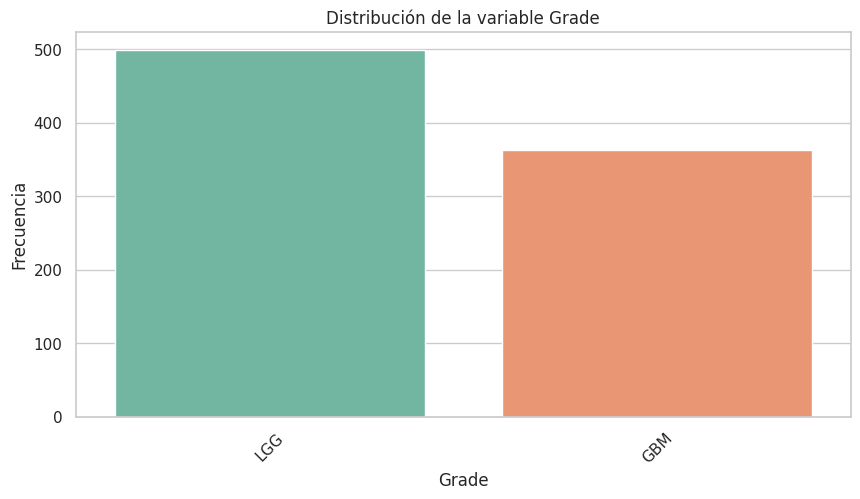

<ipython-input-124-3132431b4eef>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  chart = sns.countplot(x=col, data=df, palette='Set2')  # Crea un gráfico de barras


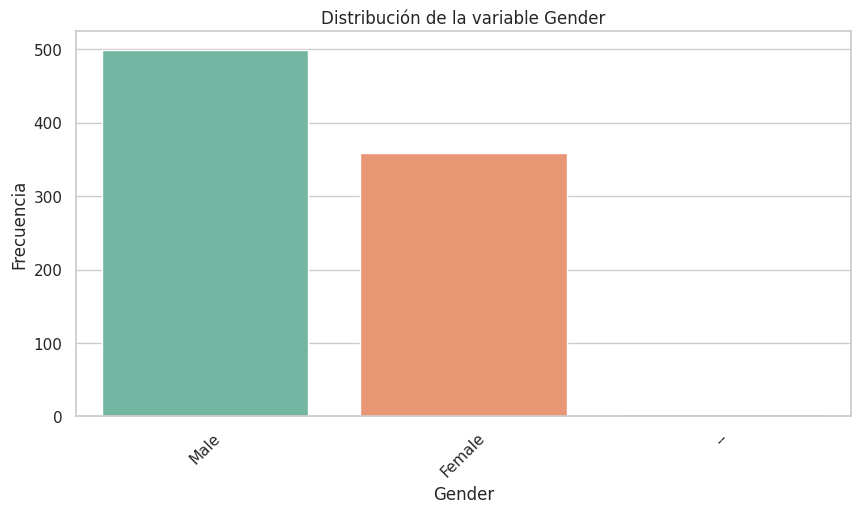

<ipython-input-124-3132431b4eef>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  chart = sns.countplot(x=col, data=df, palette='Set2')  # Crea un gráfico de barras


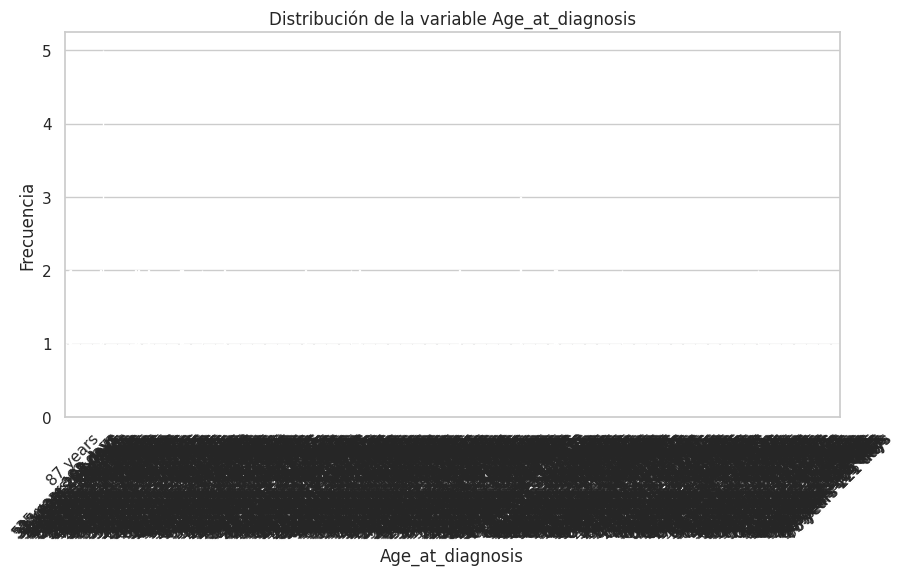

<ipython-input-124-3132431b4eef>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  chart = sns.countplot(x=col, data=df, palette='Set2')  # Crea un gráfico de barras


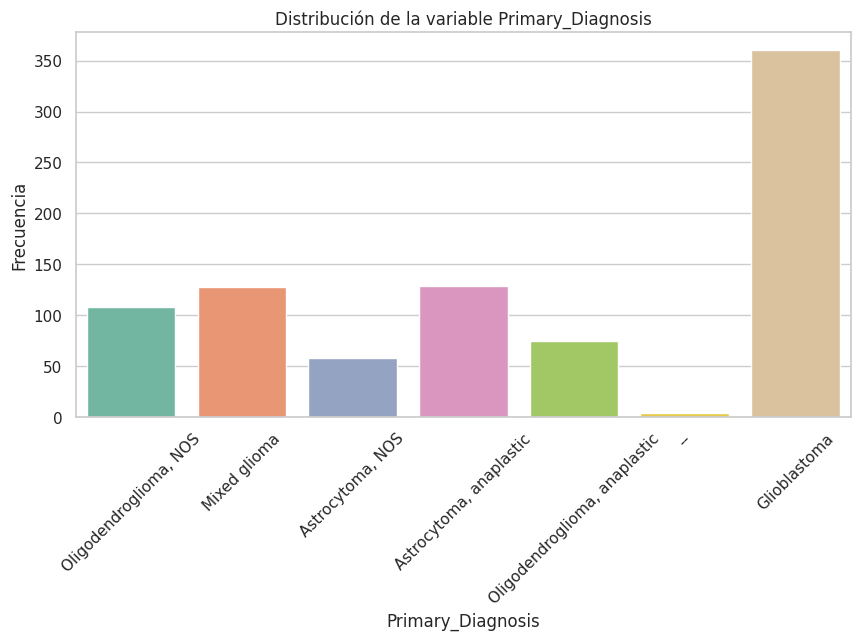

<ipython-input-124-3132431b4eef>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  chart = sns.countplot(x=col, data=df, palette='Set2')  # Crea un gráfico de barras


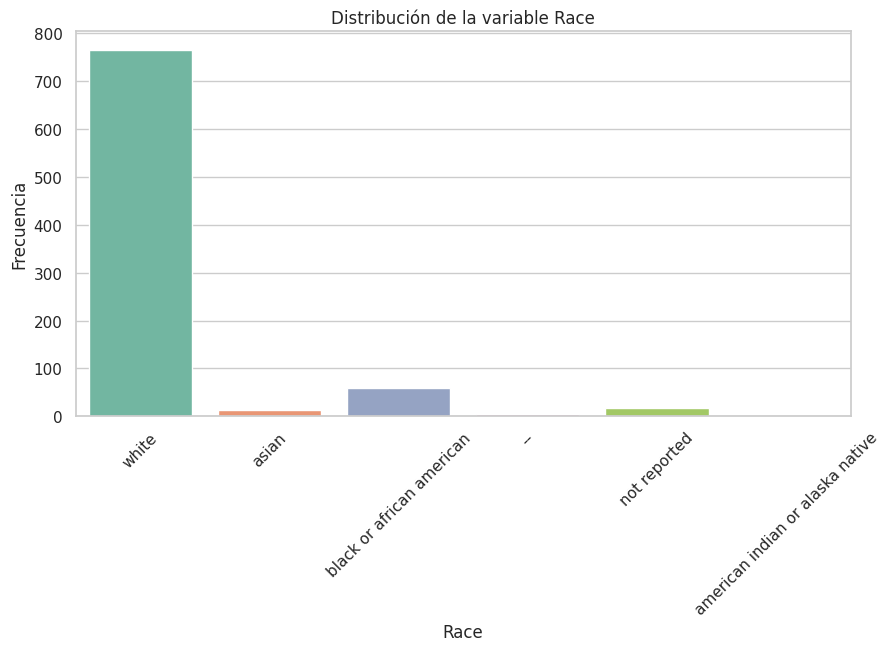

<ipython-input-124-3132431b4eef>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  chart = sns.countplot(x=col, data=df, palette='Set2')  # Crea un gráfico de barras


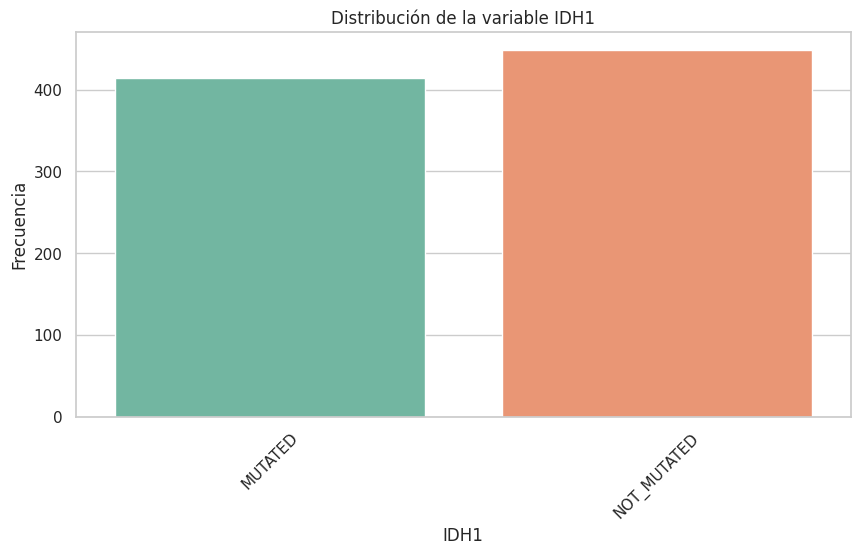

<ipython-input-124-3132431b4eef>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  chart = sns.countplot(x=col, data=df, palette='Set2')  # Crea un gráfico de barras


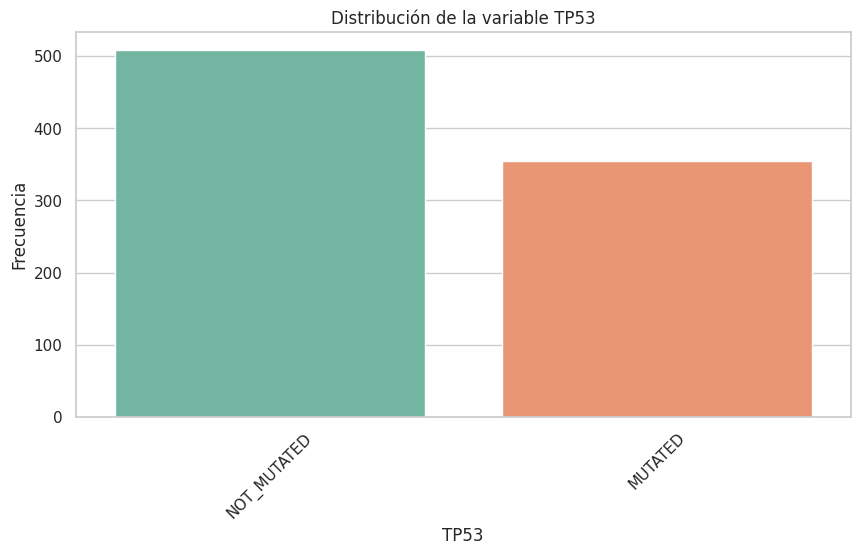

<ipython-input-124-3132431b4eef>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  chart = sns.countplot(x=col, data=df, palette='Set2')  # Crea un gráfico de barras


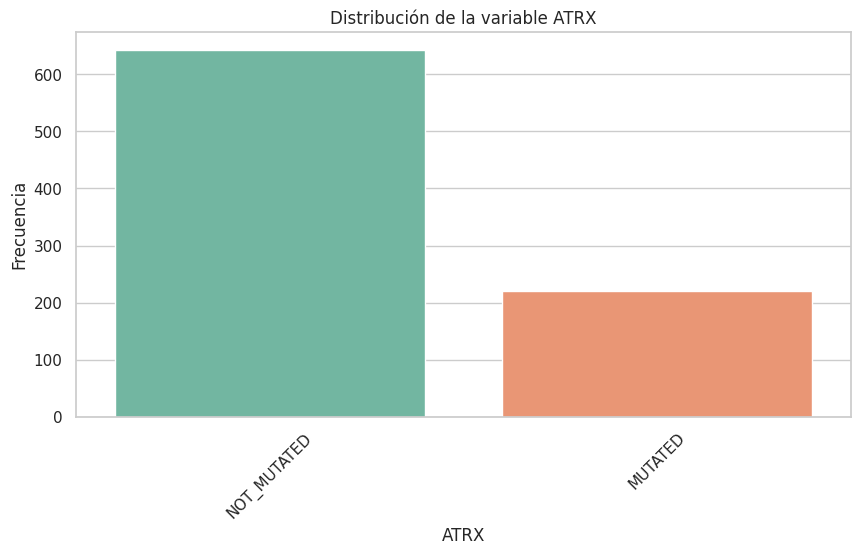

<ipython-input-124-3132431b4eef>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  chart = sns.countplot(x=col, data=df, palette='Set2')  # Crea un gráfico de barras


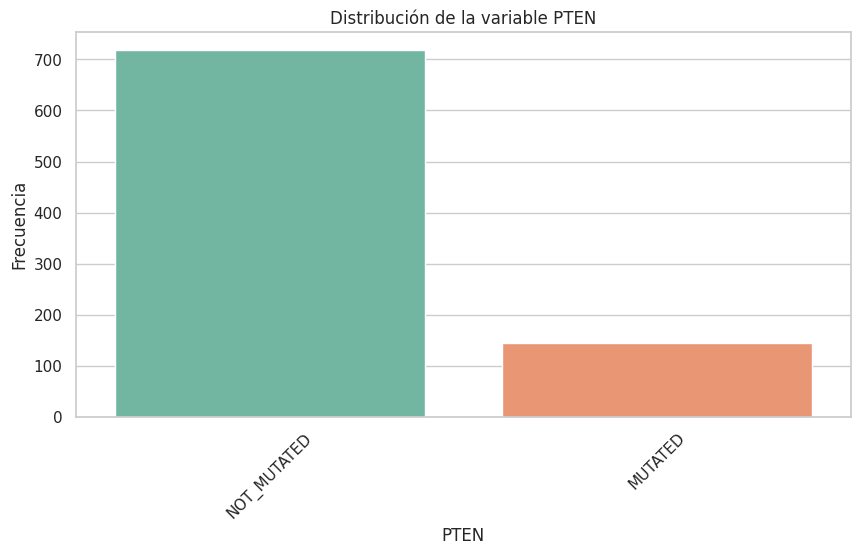

<ipython-input-124-3132431b4eef>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  chart = sns.countplot(x=col, data=df, palette='Set2')  # Crea un gráfico de barras


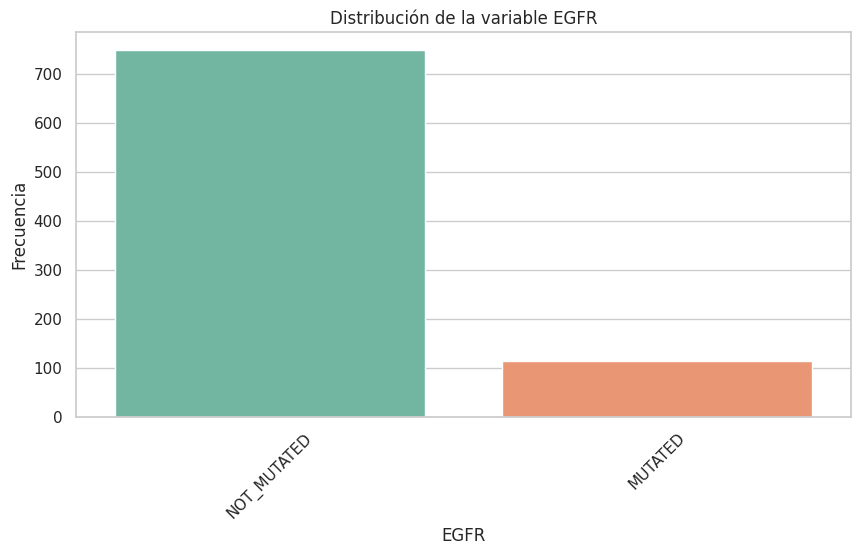

<ipython-input-124-3132431b4eef>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  chart = sns.countplot(x=col, data=df, palette='Set2')  # Crea un gráfico de barras


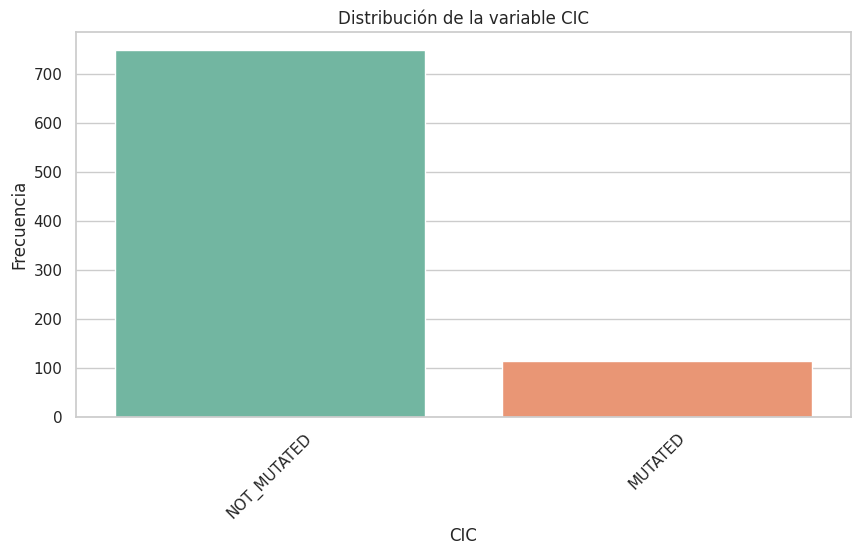

<ipython-input-124-3132431b4eef>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  chart = sns.countplot(x=col, data=df, palette='Set2')  # Crea un gráfico de barras


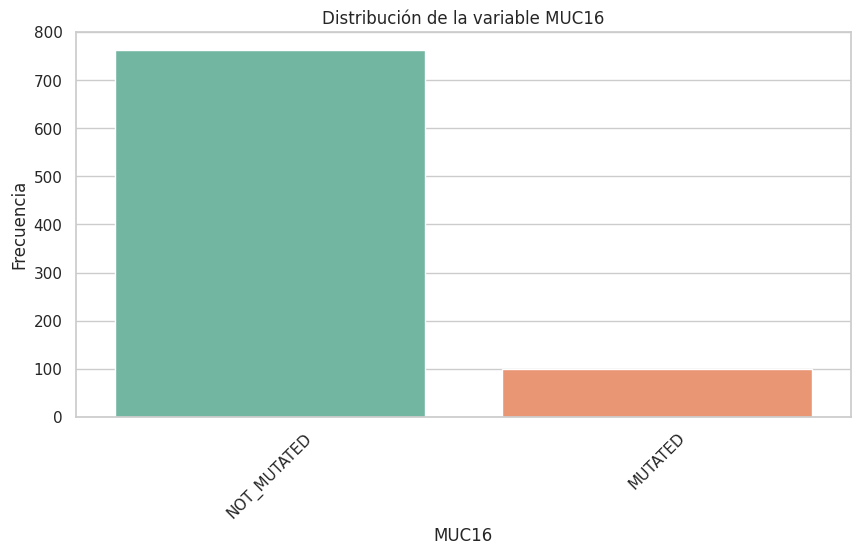

<ipython-input-124-3132431b4eef>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  chart = sns.countplot(x=col, data=df, palette='Set2')  # Crea un gráfico de barras


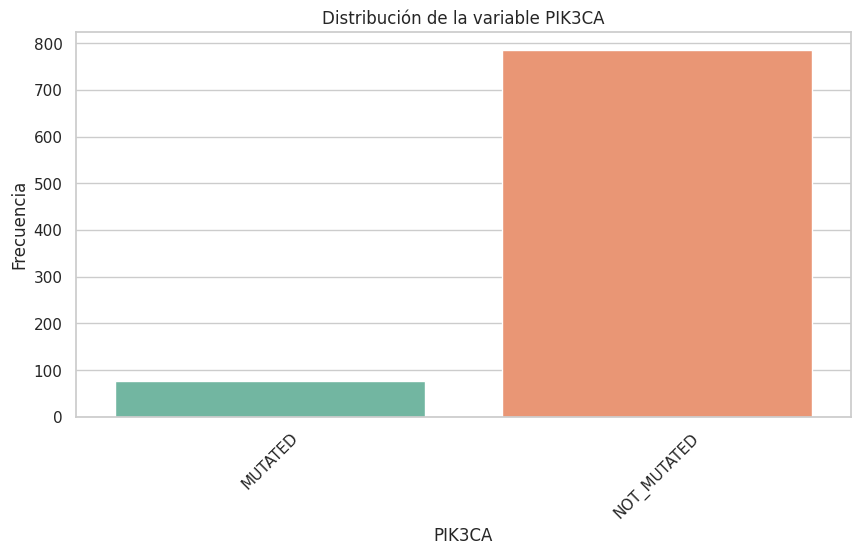

<ipython-input-124-3132431b4eef>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  chart = sns.countplot(x=col, data=df, palette='Set2')  # Crea un gráfico de barras


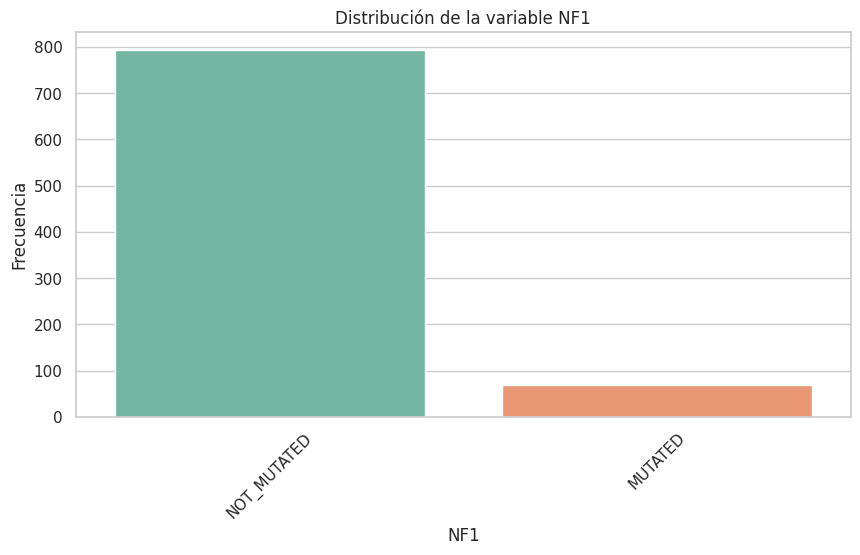

<ipython-input-124-3132431b4eef>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  chart = sns.countplot(x=col, data=df, palette='Set2')  # Crea un gráfico de barras


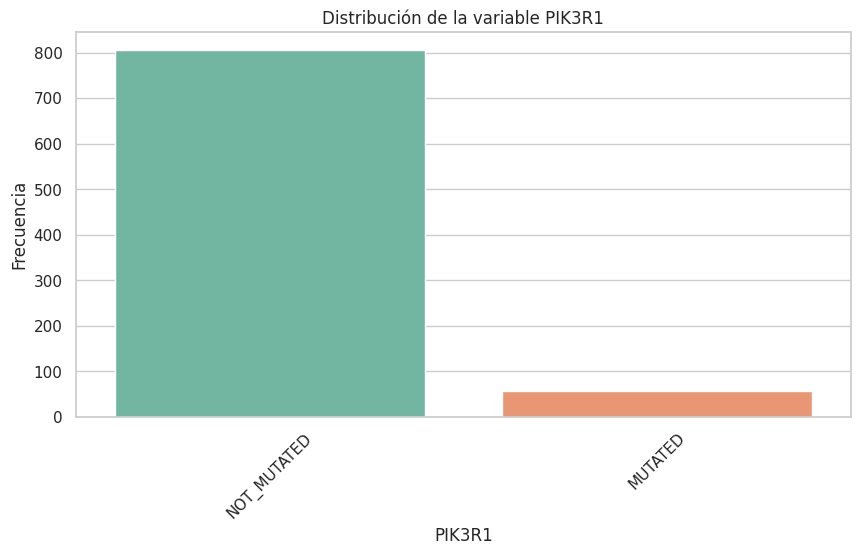

<ipython-input-124-3132431b4eef>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  chart = sns.countplot(x=col, data=df, palette='Set2')  # Crea un gráfico de barras


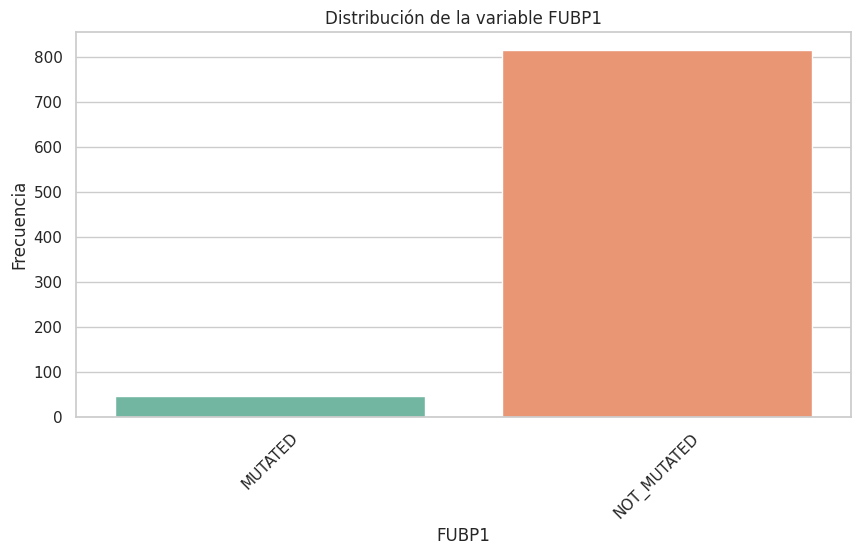

<ipython-input-124-3132431b4eef>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  chart = sns.countplot(x=col, data=df, palette='Set2')  # Crea un gráfico de barras


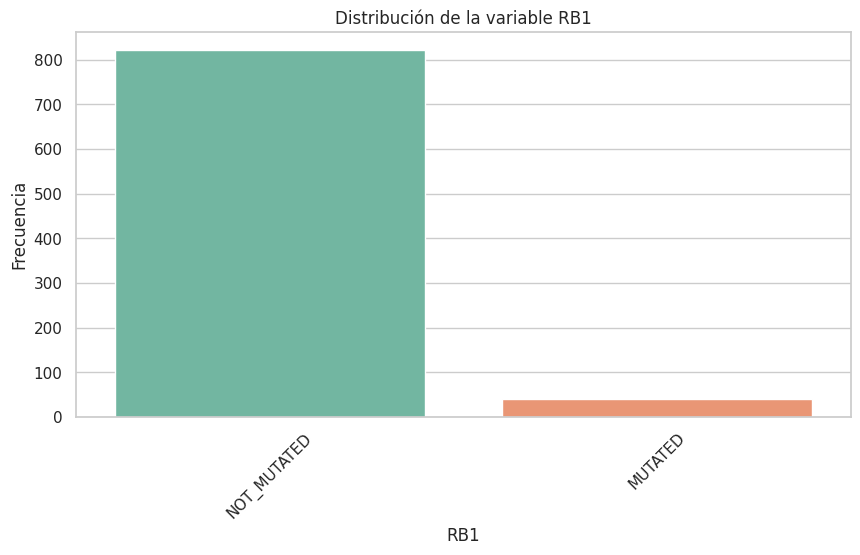

<ipython-input-124-3132431b4eef>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  chart = sns.countplot(x=col, data=df, palette='Set2')  # Crea un gráfico de barras


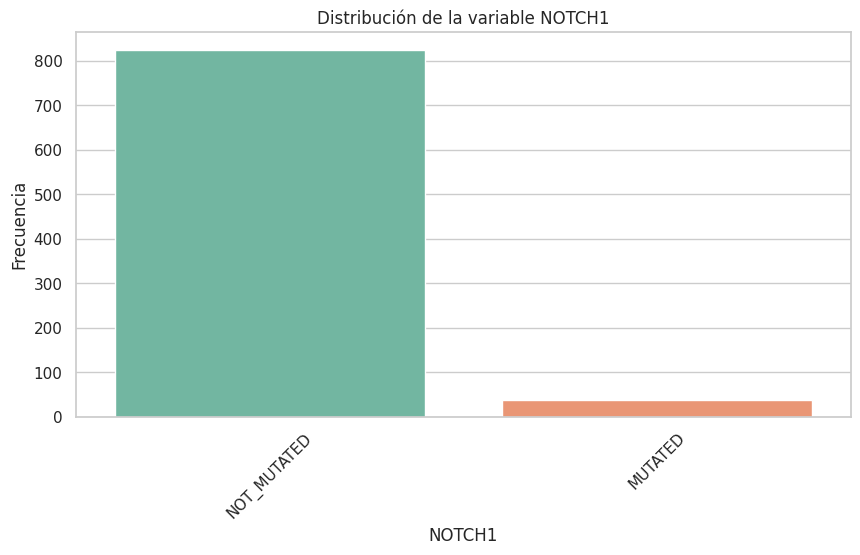

<ipython-input-124-3132431b4eef>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  chart = sns.countplot(x=col, data=df, palette='Set2')  # Crea un gráfico de barras


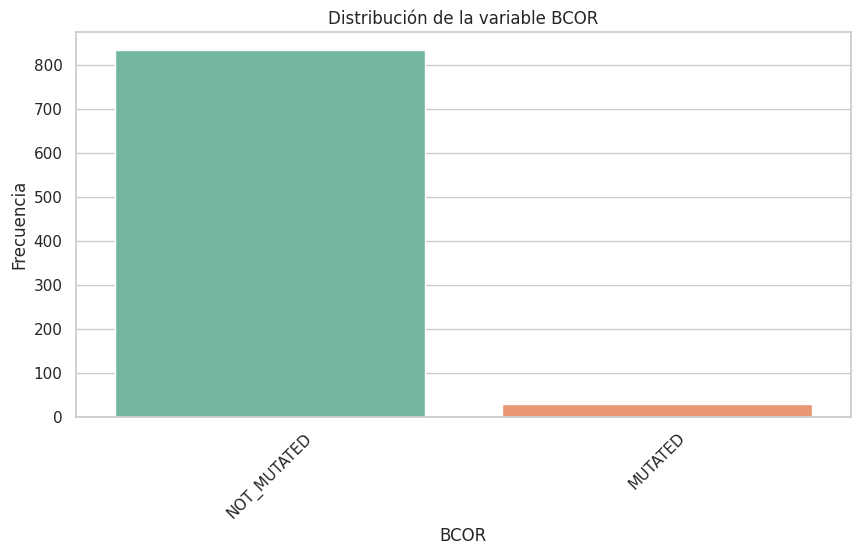

<ipython-input-124-3132431b4eef>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  chart = sns.countplot(x=col, data=df, palette='Set2')  # Crea un gráfico de barras


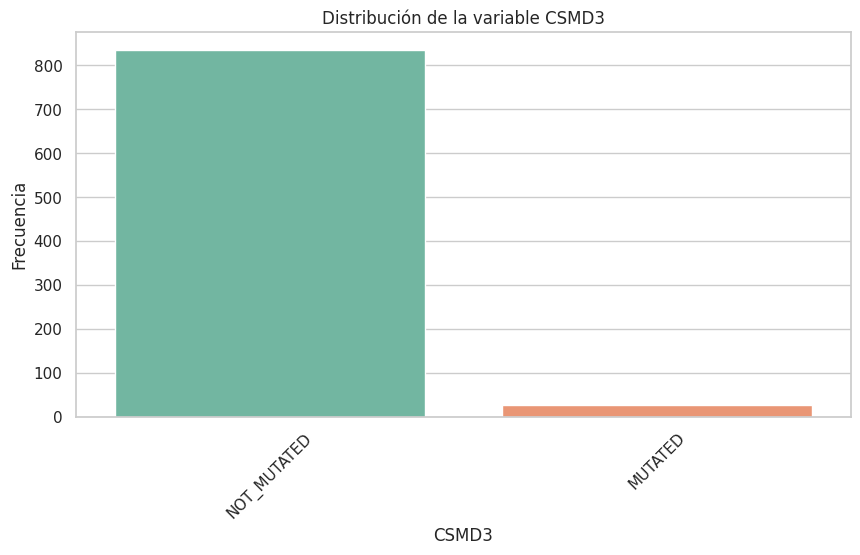

<ipython-input-124-3132431b4eef>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  chart = sns.countplot(x=col, data=df, palette='Set2')  # Crea un gráfico de barras


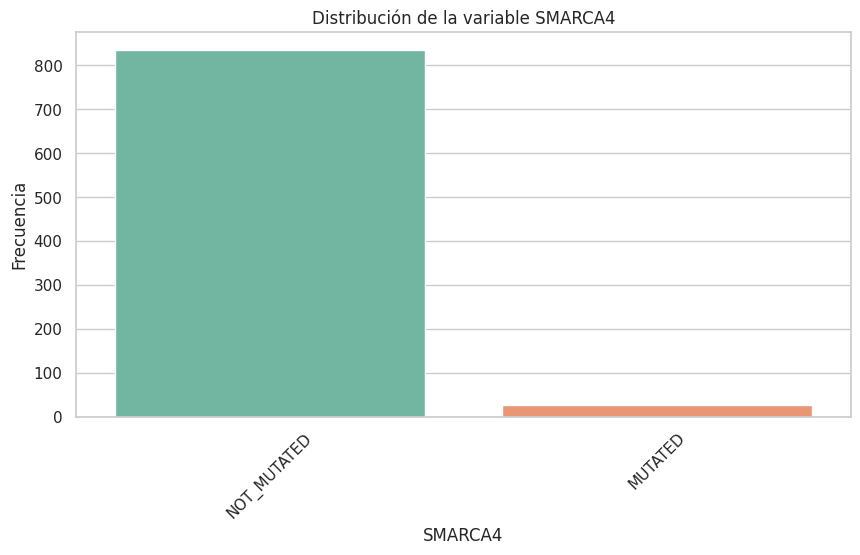

<ipython-input-124-3132431b4eef>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  chart = sns.countplot(x=col, data=df, palette='Set2')  # Crea un gráfico de barras


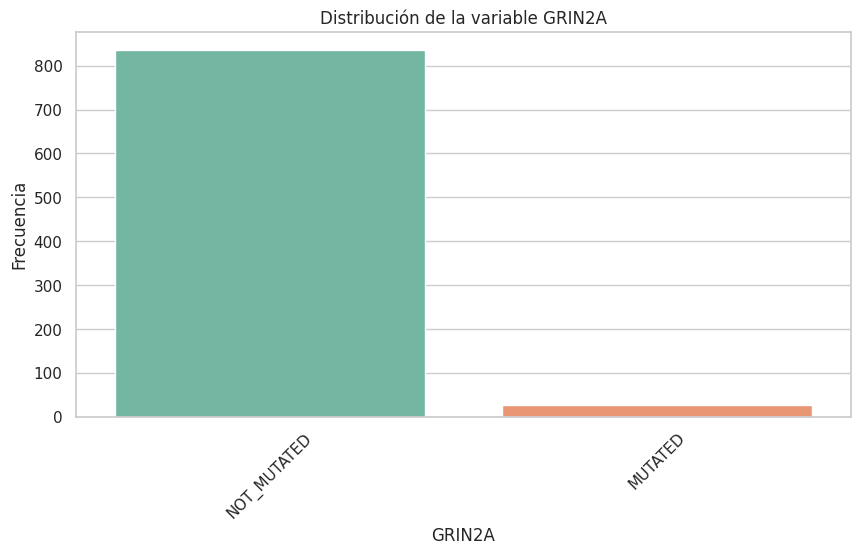

<ipython-input-124-3132431b4eef>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  chart = sns.countplot(x=col, data=df, palette='Set2')  # Crea un gráfico de barras


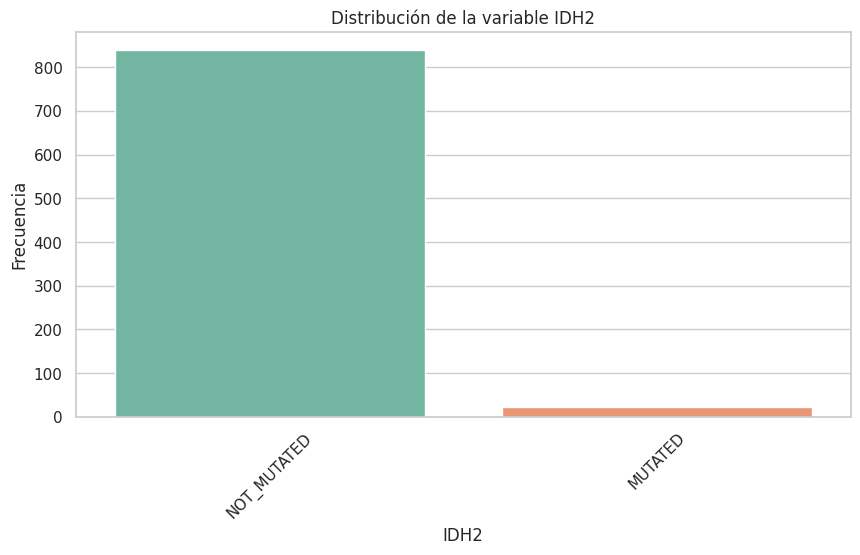

<ipython-input-124-3132431b4eef>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  chart = sns.countplot(x=col, data=df, palette='Set2')  # Crea un gráfico de barras


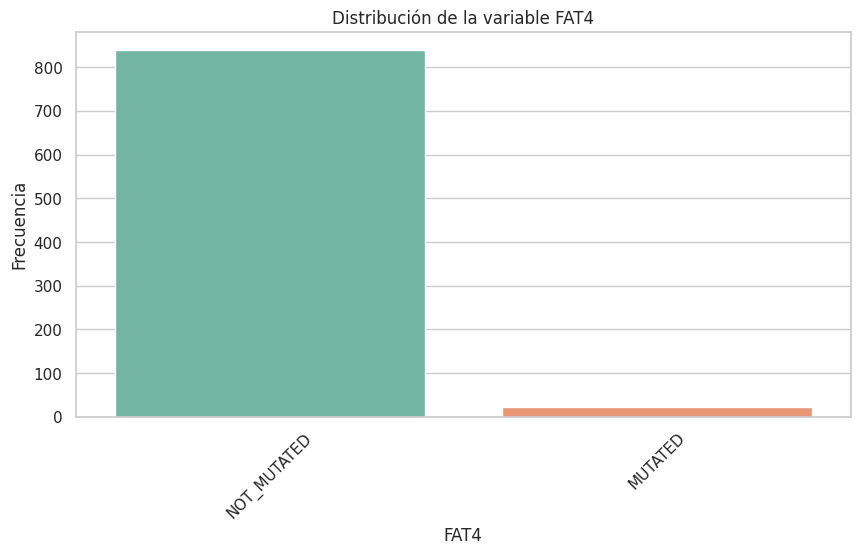

<ipython-input-124-3132431b4eef>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  chart = sns.countplot(x=col, data=df, palette='Set2')  # Crea un gráfico de barras


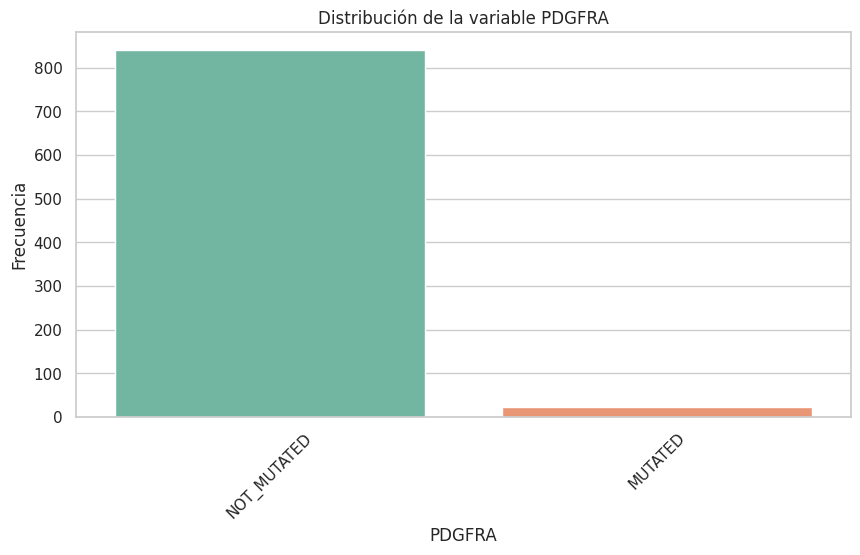

In [124]:

# Selecciona solo las columnas categóricas
categorical_cols = df.select_dtypes(include=['object']).columns

# Configura el estilo visual de los gráficos
sns.set(style="whitegrid")

# Crea un gráfico de barras para cada variable categórica
for col in categorical_cols:
    plt.figure(figsize=(10, 5))  # Define el tamaño de la figura
    chart = sns.countplot(x=col, data=df, palette='Set2')  # Crea un gráfico de barras
    plt.title(f'Distribución de la variable {col}')
    plt.xticks(rotation=45)  # Rota las etiquetas del eje x para mejorar la legibilidad
    plt.xlabel(col)  # Etiqueta del eje x
    plt.ylabel('Frecuencia')  # Etiqueta del eje y

    # Mejora en la visualización de las etiquetas si son muchas
    for item in chart.get_xticklabels():
        item.set_rotation(45)  # Rota cada etiqueta para evitar superposición

    plt.show()



A continuación, determinamos cual es la característica principal de nuestro estudio y por lo tanto la variable que nos interesa predecir.
En este caso la varible objetivo es "Primary_Diagnosis", pues es la que indica a que categoría de cancer pertenece el diagnóstico

Así, "Primary_Diagnosis" será predicha o más bien será explicada por el conjunto del resto de características de cada caso.

In [125]:
# Separar las características (X) y la variable objetivo (y)
X = df.drop('Primary_Diagnosis', axis=1)
y = df['Primary_Diagnosis']

Ahora realizamos una separación estandar(20-80) de datos de entrenamiento y datos de prueba para entrenar un modelo de predicción. Es decir, obtendremos de forma aleatoria un conjunto de entrenamiento con el 80% de los datos y reservaremos un 20% para poner a prueba el modelo.

In [126]:
# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Comenzamos seleccionando todas las columnas en X_train que son de tipo 'object'(en este caso todas), que indican variables categóricas.

In [127]:
# Preprocesamiento para variables categóricas
categorical_cols = X_train.select_dtypes(include=['object']).columns

Con **OneHotEncoder** convertimos variables categóricas en un formato numérico que puede ser utilizado por modelos de aprendizaje automático, creando una columna binaria para cada categoría.

**handle_unknown='ignore'** ignora categorías en los datos de prueba que no se vieron en los datos de entrenamiento.

Y con **sparse=False** hacemos que la salida sea una matriz densa, que es más fácil de manipular en Pandas.

Luego obtenemos los nombres de las nuevas columnas generadas por la codificación One-Hot para mantener un seguimiento claro de qué columnas corresponden a qué características categóricas.

In [128]:
# Manejo de variables categóricas
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
X_train_encoded = enc.fit_transform(X_train[categorical_cols])
X_test_encoded = enc.transform(X_test[categorical_cols])

# Obtener los nombres de las nuevas columnas
encoded_feature_names = enc.get_feature_names_out(categorical_cols)



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


A continuación convertimos las matrices codificadas en DataFrames de Pandas para facilitar operaciones futuras, como concatenar con otras columnas. Además, se combinan las características numéricas originales (después de eliminar las categóricas) con las nuevas características categóricas codificadas, formando el conjunto final de entrenamiento y prueba.

In [129]:
# Convertir los datos codificados en un DataFrame
X_train_encoded = pd.DataFrame(X_train_encoded, columns=encoded_feature_names)
X_test_encoded = pd.DataFrame(X_test_encoded, columns=encoded_feature_names)

# Combinar las características codificadas con las numéricas
X_train_final = pd.concat([X_train.drop(categorical_cols, axis=1).reset_index(drop=True), X_train_encoded.reset_index(drop=True)], axis=1)
X_test_final = pd.concat([X_test.drop(categorical_cols, axis=1).reset_index(drop=True), X_test_encoded.reset_index(drop=True)], axis=1)

Para mejorar la robustez y precisión del modelo, **RandomForestClassifier** es un modelo de ensamble que utiliza múltiples árboles de decisión.
Con **fit** entrenamos el modelo usando los datos que hemos ido procesando.

In [130]:
# Entrenar el clasificador
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train_final, y_train)

RandomForestClassifier(random_state=42)

A continuación usamos el modelo entrenado para predecir las etiquetas de los datos de prueba.
Finalmente evaluamos la precisión del modelo comparando las predicciones con las verdaderas etiquetas de prueba.

In [131]:
# Predecir sobre el conjunto de prueba
y_pred = rf_classifier.predict(X_test_final)

# Calcular la precisión del modelo
accuracy = accuracy_score(y_test, y_pred)
print("Precisión del clasificador RandomForest:", accuracy)

Precisión del clasificador RandomForest: 0.6358381502890174


Por último, se selecciona una muestra aleatoria de 10 registros de X, se aplica el mismo preprocesamiento de codificación One-Hot a los nuevos datos y se realiza predicciones para los datos reservados con este fin; obteniendo finalmente los resultados del modelo.

In [132]:
# Predecir la clase de al menos 10 clientes que no se hayan utilizado para entrenar el modelo
new_data = X.sample(10, random_state=42)
new_data_encoded = enc.transform(new_data[categorical_cols])
new_data_encoded = pd.DataFrame(new_data_encoded, columns=encoded_feature_names)
new_data_final = pd.concat([new_data.drop(categorical_cols, axis=1).reset_index(drop=True), new_data_encoded.reset_index(drop=True)], axis=1)

new_data_predictions = rf_classifier.predict(new_data_final)
print("Predicciones para nuevos datos:")
print(new_data)
print("Clases predichas:")
print(new_data_predictions)

Predicciones para nuevos datos:
    Grade  Gender   Age_at_diagnosis                       Race         IDH1  \
715   GBM    Male  78 years 271 days                      white  NOT_MUTATED   
605   GBM    Male  62 years 190 days                      white  NOT_MUTATED   
120   LGG  Female   37 years 83 days  black or african american      MUTATED   
208   LGG    Male  47 years 335 days               not reported      MUTATED   
380   LGG    Male   28 years 26 days                      white      MUTATED   
817   GBM  Female  66 years 320 days                      white  NOT_MUTATED   
575   GBM  Female  68 years 108 days                      white  NOT_MUTATED   
266   LGG    Male  36 years 311 days                      white      MUTATED   
557   GBM    Male  53 years 145 days                      white  NOT_MUTATED   
826   GBM    Male  79 years 183 days  black or african american  NOT_MUTATED   

            TP53         ATRX         PTEN         EGFR          CIC  ...  \
715  NOT_M

Aunque la precisión obtenida no es especialmente alta (63.58%, y por lo tanto error de 36,42%), especialmente tratandose de un estudio en el ámbito de la medicina, debemos tener en cuenta que es un problema muy complejo y hay multiples factores que no están siendo considerados.
Por ejemplo, un posible desbalance de clases en los datos debido a que hay tipos de cancer más comunes que otros, o que algunos de los genes podrían tener un impacto mucho mayor que otros en el diagnóstico.

Aun así apreciamos que el modelo ha predicho multiples clases, lo cual es un indicador de que no esta sesgado. Además, haciendo un análisis superficial de los resultados parece que se podría obtener información relevante como los tipos de cancer más comunes en función al grupo de edad.

En definitiva, consideramos que es un modelo que cumple con lo esperado y sienta muy buenas bases para trabajar en este tipo de problematicas.

# PRÁCTICA 3: DETECCIÓN DE MALWARE

Descomprimimos la carpeta comprimida Malware.zip

In [133]:
import os
import zipfile

base_dir = 'Recursos Lab3/'
zip_filename = 'Malware.zip'

output_dir = os.path.splitext(zip_filename)[0] + '/'
output_dir = os.path.join(base_dir, output_dir)

if not os.path.exists(output_dir):
    with zipfile.ZipFile(os.path.join(base_dir, zip_filename)) as zf:
        zf.extractall(path=base_dir)

Con opencv-python convertimos las imágenes a numpy arrays.  
Para almacenar las imágenes creamos un diccionario que lleva por claves las 4 posibles clases y como valores listas que contienen los numpy arrays.

Adicionalmente comprobamos los tamaños de las imágenes, nadie nos garantiza que todas o dentro de cada carpeta se tenga un único tamaño.  
Utilizamos set() para detectar los diferentes tamaños únicos existentes.

In [134]:
import cv2

labels = os.listdir(output_dir)
data = dict()
shapes = dict()

for label in labels:

    class_dir = os.path.join(output_dir, label)

    data[label] = []
    shapes[label] = []

    for image in os.listdir(class_dir):

        image = cv2.imread(os.path.join(class_dir, image), cv2.IMREAD_GRAYSCALE)

        data[label].append(image)
        shapes[label].append(image.shape)

    shapes[label] = list(set(shapes[label]))

data[labels[0]][0], shapes[labels[0]]

(array([[ 77,  90, 144, ...,   0,   0,   0],
        [  0,   0,   0, ...,  85,  70,   0],
        [ 80, 255,  21, ...,   0,  80, 232],
        ...,
        [226,  75, 188, ...,  20, 178,  68],
        [222,  80, 215, ...,  91, 105,  71],
        [  5, 139, 164, ...,  67, 253,  66]], dtype=uint8),
 [(683, 768)])

Se observa que tienen dimensiones distintas, tanto fuera como dentro de una misma clase, tomaremos como dimensiones estándar las menores existentes (de manera independiente la menor X y la menor Y)

In [135]:
min_dim = dict()
for label in labels:
    min_dim[label] = shapes[label][0]  # start with shape[0] as min
    for shape in shapes[label][1:]:
        min_dim[label] = min(min_dim[label][0], shape[0]), min(min_dim[label][1], shape[1])

std_dim = min(min_dim.values())
std_dim

(208, 64)

A continuación, se redimensionan las imágenes a la dimensión estándar

In [136]:
for label in labels:
    for i, image in enumerate(data[label]):
        data[label][i] = cv2.resize(image, std_dim[::-1]) # due to cv2.resize use (width, height) we reverse dimensions

Podemos comprobar que la redimensión ha tenido éxito stackeando los numpy arrays por etiqueta, que además es un formato más conveniente cuando se trabaja con tensores

In [137]:
import numpy as np
from copy import deepcopy

ds = deepcopy(data)

for label in labels:
    ds[label] = np.stack(data[label])
    print(label, ds[label].shape)

Yuner.A (173, 208, 64)
Fakerean (59, 208, 64)
Lolyda.AA1 (167, 208, 64)
Agent.FYI (66, 208, 64)


Podemos ver un ejemplo de cada clase

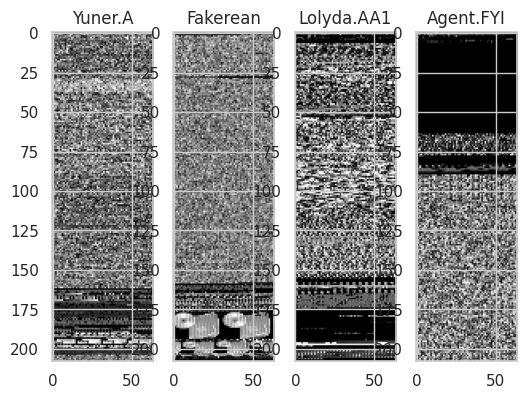

In [138]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 4, figsize=(6, 6))

for idx, label in enumerate(data):
    axs[idx].imshow(ds[label][0], cmap='gray')
    axs[idx].set_title(label)

plt.show()

Definimos dos tensores:  
- Imágenes (X)
- Etiquetas (y)

In [139]:
import numpy as np

X = np.array([x for label in labels for x in ds[label]])
y = np.array([labels.index(label) for label in labels for idx in range(len(ds[label]))])

X.shape, y.shape

((465, 208, 64), (465,))

En total contamos con 465 imágenes de dimensiones (height, width) = (208, 64) y 465 etiquetas de dimensión ()

### 1) Crea un clasificador, realiza al menos tres configuraciones y dibuja una tabla donde se muestre la precisión  con  la  que  clasifican.  ¿Cómo  funcionaría  si  no  usamos  kernels?  ¿Y  al  usar  distintos kernels?

Dividimos en datos de train y test, adicionalmente utilizamos namedtuples por legibilidad.   
Nota: Reservamos 10 imágenes para el segundo apartado del ejercicio.

In [140]:
seed = 42
n = 10
np.random.seed(seed=seed)
random_10_index = np.random.choice(X.shape[0], n, replace=False)

X_10 = X[random_10_index, :, :]
X = np.delete(X, random_10_index, axis=0)

y_10 = y[random_10_index]
y = np.delete(y, random_10_index, axis=0)

X.shape, y.shape

((455, 208, 64), (455,))

In [141]:
from sklearn.model_selection import train_test_split
from collections import namedtuple

seed = 42
test_ratio = 0.2

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=test_ratio, shuffle=True)

Dataset = namedtuple('Dataset', ['X', 'y'])

ds_train = Dataset(X_train, y_train)
ds_test = Dataset(X_test, y_test)

print("Train:", ds_train.X.shape, ds_train.y.shape)
print("Test:", ds_test.X.shape, ds_test.y.shape)

Train: (364, 208, 64) (364,)
Test: (91, 208, 64) (91,)


In [142]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from functools import partial
from sklearn.preprocessing import FunctionTransformer

flatten = lambda x: np.reshape(x, newshape=(x.shape[0], -1))
flatten = FunctionTransformer(flatten)

clf = make_pipeline(flatten, StandardScaler(), SVC(gamma='auto'))
clf.fit(ds_train.X, ds_train.y)

y_pred = clf.predict(ds_test.X)
y_pred

array([2, 0, 3, 3, 0, 2, 2, 0, 3, 0, 0, 1, 0, 2, 2, 0, 0, 2, 2, 0, 0, 0,
       2, 0, 2, 1, 0, 3, 0, 2, 2, 2, 3, 0, 3, 0, 2, 2, 0, 0, 2, 0, 3, 0,
       0, 0, 0, 2, 3, 2, 2, 0, 2, 3, 0, 2, 0, 3, 0, 3, 1, 0, 0, 2, 2, 0,
       3, 2, 2, 1, 3, 2, 0, 1, 2, 3, 0, 2, 3, 0, 1, 2, 2, 0, 0, 3, 3, 0,
       0, 0, 0])

In [143]:
from sklearn.metrics import accuracy_score

y_true = ds_test.y
accuracy_score(y_true, y_pred)

1.0

El modelo parece funcionar, probamos ahora 3 configuraciones distintas:

In [144]:
from sklearn.metrics import accuracy_score
configs = [
    {'kernel': 'poly'},
    {'kernel': 'linear'},
    {'kernel': 'rbf'},
    ]

classifiers = list()
y_preds = dict()
for cfg in configs:
  clf = make_pipeline(flatten, StandardScaler(), SVC(gamma='auto', **cfg))
  clf.fit(ds_train.X, ds_train.y)
  classifiers.append(clf)
  y_preds[cfg['kernel']] = clf.predict(ds_test.X)

y_true = ds_test.y
print('--------------------------')
print('Resultados')
print('--------------------------')
for cfg, y_pred in y_preds.items():
  print(cfg, '\t', accuracy_score(y_true, y_pred))

--------------------------
Resultados
--------------------------
poly 	 0.967032967032967
linear 	 1.0
rbf 	 1.0


Como resultados obtenemos que los modelos de kernel **lineal** y **rbf** aciertan todas las imágenes de test, mientras que el modelo de kernel **poly** acierta el 96.70%.

### 2) Elige 10 imágenes que no hayas usado ni para entrenar el modelo, ni para evaluarlo y clasifícalas. Usa para ello el modelo que mejor clasifique de los del punto anterior. Índica con que error o acierto ha funcionado el clasificador. (1 punto)

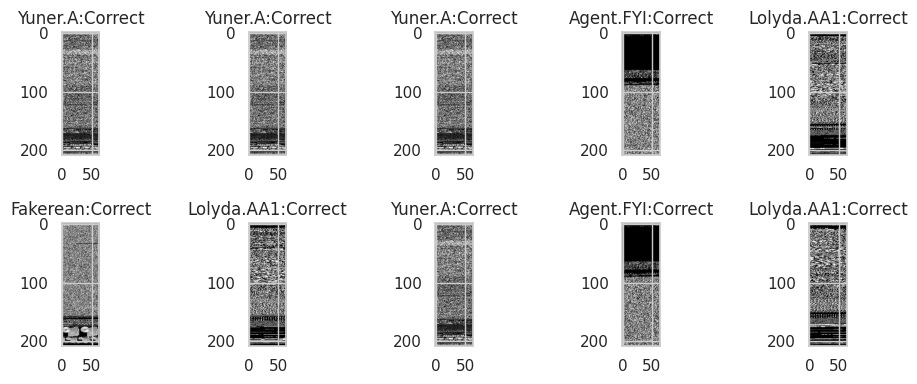

In [145]:
import numpy as np
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 5, figsize=(10, 4))
y_pred = classifiers[2].predict(X_10)

for i, ax in enumerate(axs.flat):
  ax.imshow(X_10[i], cmap='gray')

  label = labels[y_10[i]]
  if y_pred[i] == y_10[i]:
    msg = 'Correct'
  else:
    msg = 'Incorrect'

  ax.set_title(label + ':' + msg)

plt.tight_layout()

plt.show()

In [146]:
print('--------------------------')
print('Resultados')
print('--------------------------')
print('rbf', '\t', accuracy_score(y_10, y_pred))

--------------------------
Resultados
--------------------------
rbf 	 1.0


Como resultado se ha obtenido que el modelo acierta las 10 imágenes aleatorias que hemos elegido y que no formaban parte del entrenamiento o la evaluación.

# PRÁCTICA 4: DIAGNÓSTICO DE CÁNCER CON GÉNES

### Importación de las librerías necesarias

In [147]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

### Carga de la base de datos

In [148]:
df = pd.read_csv("Recursos Lab3/genes.csv")
df.head()

,Gene1,Gene2,CancerPresent
0,4.3,3.9,1
1,2.5,6.3,0
2,5.7,3.9,1
3,6.1,6.2,0
4,7.4,3.4,1


### Apartado 1
Creación de un set de entrenamiento, otro de validación y uno de test.
Para ello, primero vamos a dividir el dataset en dos:
 - X: Características de las observaciones
 - y: Etiquetas de los datos

In [149]:
X = df[['Gene1', 'Gene2']]
y = df['CancerPresent']

Vamos a visualizar como se comportan los datos del DataFrame:

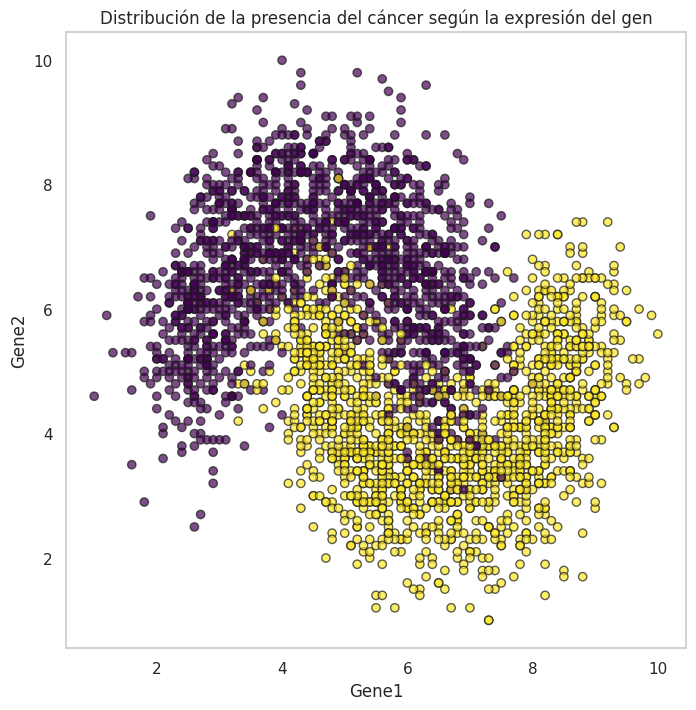

In [150]:
plt.figure(figsize=(8, 8))
scatter = plt.scatter(X['Gene1'], X['Gene2'], c=y, cmap='viridis', edgecolor='k', alpha=0.7)
plt.xlabel('Gene1')
plt.ylabel('Gene2')
plt.title('Distribución de la presencia del cáncer según la expresión del gen')
plt.grid(False)
plt.show()

<div style="text-align: justify">
Parece que los datos están algo mezclados, con algunas áreas donde los puntos morados y amarillos se superponen, dichas áreas van a provocar problemas en la clasificación. Sin embargo, hay regiones donde se podría trazar una línea o curva que separara en gran medida los dos conjuntos.
</div>

<div style="text-align: justify">
A continuación, dividimos los datos en conjuntos de entrenamiento y prueba. Dentro de los datos de entrenamiento, realizamos una segunda partición para crear datos de validación:
</div>

In [151]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)
X_train.shape, y_train.shape, X_val.shape,y_val.shape, X_test.shape, y_test.shape

((1800, 2), (1800,), (600, 2), (600,), (600, 2), (600,))

### Apartados 2 y 3

A continuación, se normalizan los datos para facilitar la convergencia del algoritmo y reducir la complejidad del cómputo:

In [152]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.fit_transform(X_val)
X_test_scaled = scaler.fit_transform(X_test)

A continuación, se empleará el algoritmo de los K-vecinos. Dicho algoritmo acepta dos parámetros: el número K de vecinos cercanos y la métrica de distancia escogida. La función lo realiza de forma bruta con las distancias euclídea y de Manhattan. Además, solo emplea números impares para K con el fin de evitar empates en la elección de clase y $K \leq \sqrt{N}$ donde N es el número de observaciones de training:

In [153]:
def evaluate_knn(k_values, distance_metrics, X_train, y_train, X_val, y_val):
    results = []
    for k in k_values:
        for distance in distance_metrics:
            knn = KNeighborsClassifier(n_neighbors=k, metric=distance)
            knn.fit(X_train, y_train)
            y_pred = knn.predict(X_val)
            accuracy = accuracy_score(y_val, y_pred)

            results.append({
                'k': k,
                'distance_metric': distance,
                'accuracy': accuracy
            })
    return pd.DataFrame(results)

k_values = range(1, round(math.sqrt(len(X_train))), 2)
distance_metrics = ['euclidean', 'manhattan']
knn_results = evaluate_knn(k_values, distance_metrics, X_train_scaled, y_train, X_val_scaled, y_val)
knn_results.sort_values(by='accuracy', ascending=False).head()

,k,distance_metric,accuracy
24,25,euclidean,0.945000
19,19,manhattan,0.943333
20,21,euclidean,0.943333
18,19,euclidean,0.943333
22,23,euclidean,0.943333



Podemos observar en la tabla que la configuración con K = 25 y distancia euclidiana tiene la mayor precisión en los datos de validación, con una puntuación del 94.5%.

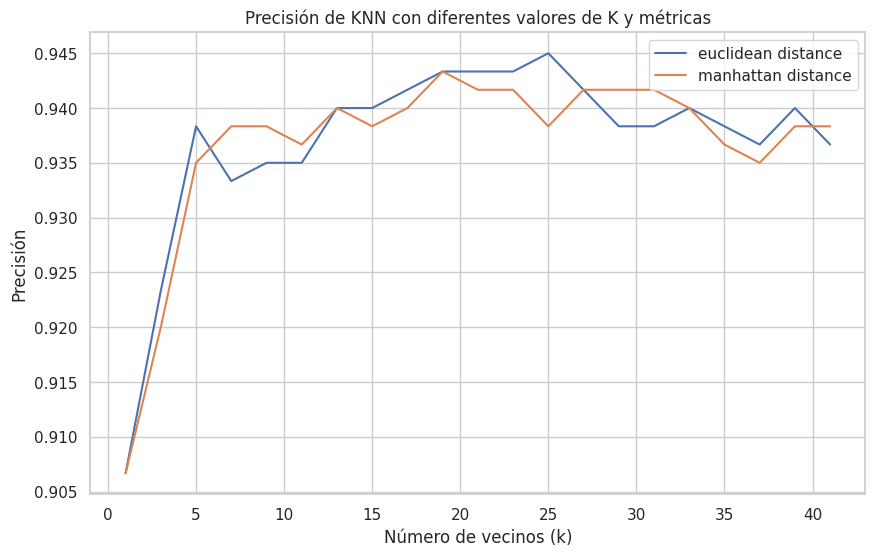

In [154]:
plt.figure(figsize=(10, 6))
for distance in distance_metrics:
    subset = knn_results[knn_results['distance_metric'] == distance]
    plt.plot(subset['k'], subset['accuracy'], label=f'{distance} distance')

plt.title('Precisión de KNN con diferentes valores de K y métricas')
plt.xlabel('Número de vecinos (k)')
plt.ylabel('Precisión')
plt.legend()
plt.grid(True)
plt.show()

<div style="text-align: justify">
En la gráfica se observa que para valores bajos de K, la precisión aumenta rápidamente, lo que sugiere que un número pequeño de vecinos cercanos es suficiente para hacer una buena clasificación en este caso. A medida que k aumenta, la precisión parece estabilizarse y fluctúa ligeramente sin una tendencia clara a la baja o al alza, lo que puede indicar que agregar más vecinos no mejora significativamente la precisión del modelo.

Ambas métricas de distancia muestran un comportamiento similar en términos de precisión a lo largo de diferentes valores de k.
</div>

<ipython-input-155-9a7fad663ba0>:23: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:


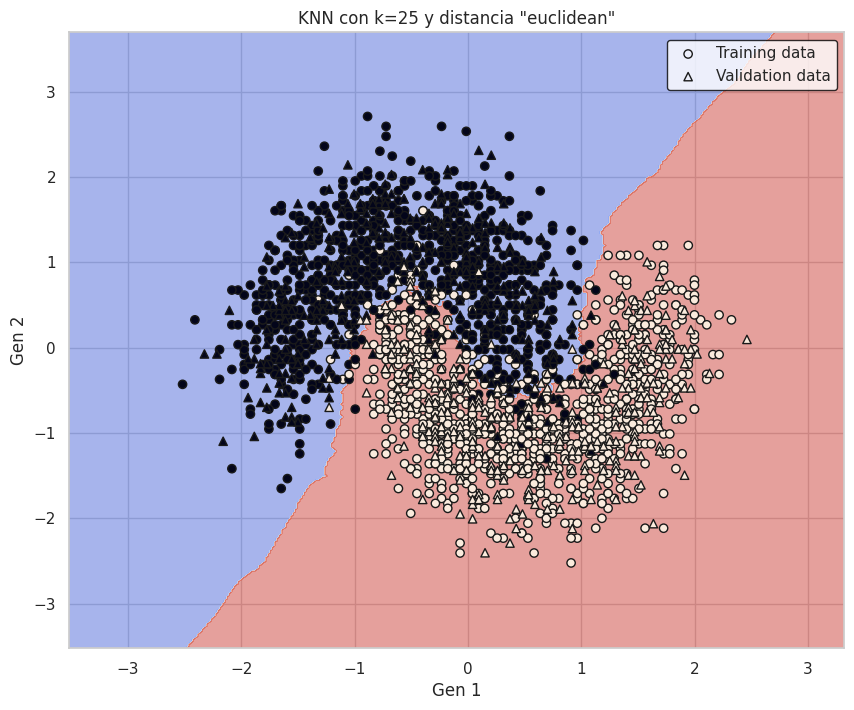

In [155]:
best_model_data = knn_results.sort_values(by='accuracy', ascending=False).iloc[0]
best_knn = KNeighborsClassifier(n_neighbors=best_model_data['k'], metric=best_model_data['distance_metric'])
best_knn.fit(X_train_scaled, y_train)

h = .02
x_min, x_max = X_train_scaled[:, 0].min() - 1, X_train_scaled[:, 0].max() + 1
y_min, y_max = X_train_scaled[:, 1].min() - 1, X_train_scaled[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = best_knn.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z, alpha=0.5, cmap=plt.cm.coolwarm)
plt.scatter(X_train_scaled[:, 0], X_train_scaled[:, 1], c=y_train, marker='o', label='Training data', edgecolors='k')
plt.scatter(X_val_scaled[:, 0], X_val_scaled[:, 1], c=y_val, marker='^', label='Validation data', edgecolors='k')
plt.xlabel('Gen 1')
plt.ylabel('Gen 2')
plt.title(f'KNN con k={best_model_data["k"]} y distancia "{best_model_data["distance_metric"]}"')

legend = plt.legend(edgecolor='black')
for handle in legend.legendHandles:
    handle.set_facecolor("none")

<div style="text-align: justify">
Podemos observar que, efectivamente, como se mencionó anteriormente, las áreas donde se superponen ambas categorías iban a ser problemáticas. No obstante, en general ha logrado clasificar correctamente ambas clases.
</div>

### Apartado 4

Creamos un nuevo .csv con los datos de test:

In [156]:
df_X = pd.DataFrame(X_test_scaled, columns=['Gene1', 'Gene2'])
df_y = pd.DataFrame(y_test, columns=['CancerPresent'])
df_y = df_y.reset_index()
df_pacientes_test = pd.concat([df_X, df_y], axis=1)
df_pacientes_test.to_csv('pacientes_test.csv', index=False)

Leemos el .csv recien generado y lo separamos en características y etiquetas:

In [157]:
df_test = pd.read_csv('pacientes_test.csv')
X_test = df_test[['Gene1', 'Gene2']]
y_test = df_test['CancerPresent']

Hacemos predicciones:

In [158]:
y_pred = best_knn.predict(X_test)

test_accuracy = accuracy_score(y_test, y_pred)
print(f'La precisión del modelo en los datos de test es: {test_accuracy}')

La precisión del modelo en los datos de test es: 0.9316666666666666


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


El modelo tiene una precisión del 93.16% con los datos de test, por tanto, se trata de un modelo bastante preciso.

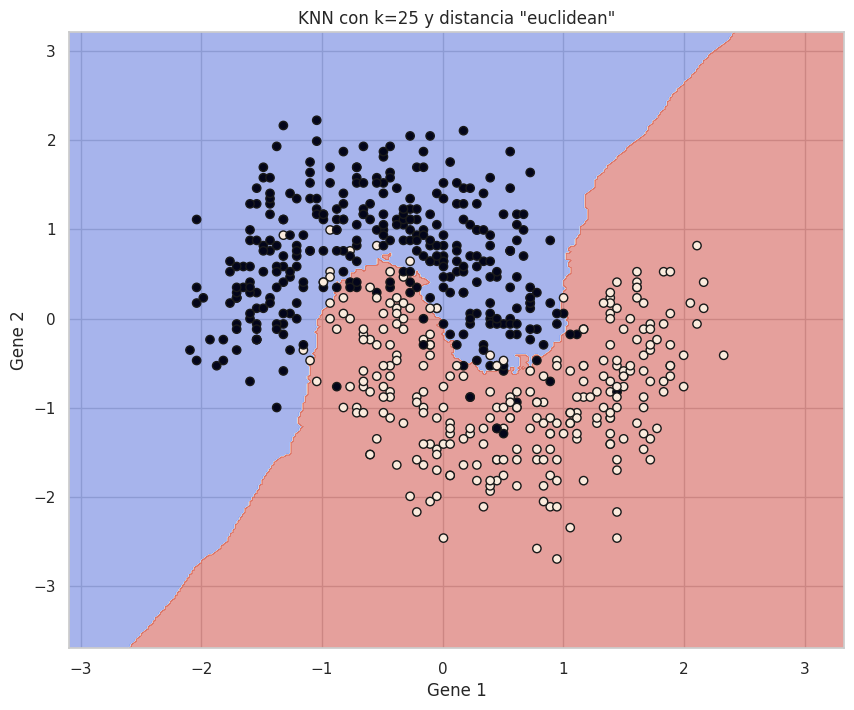

In [159]:
h = .02
x_min, x_max = X_test['Gene1'].min() - 1, X_test['Gene1'].max() + 1
y_min, y_max = X_test['Gene2'].min() - 1, X_test['Gene2'].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = best_knn.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z, alpha=0.5, cmap=plt.cm.coolwarm)
plt.scatter(X_test['Gene1'], X_test['Gene2'], c=y_test, marker='o', edgecolors='k', label='Test data')
plt.xlabel('Gene 1')
plt.ylabel('Gene 2')
plt.title(f'KNN con k={best_model_data["k"]} y distancia "{best_model_data["distance_metric"]}"')
plt.show()